In [1]:
import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
import glob
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND 
from rnn.model import Attention
import matplotlib.pyplot as plt
np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.nanmean(losses)

def evaluate(model, ldr, preproc, store_prediction=False, print_prediction=False):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    if store_prediction:
        with open("test_results.json", "w") as res:
            json.dump(results, res)

    if print_prediction:
        for (truth, pred) in results:
            print('True label:\n  ', end="")
            for char in truth:
                print(char, end=" ")
            print('\nPredicted labal:\n  ', end="")
            for char in pred:
                print(char, end=" ")
            print('')

    return np.nanmean(losses), compute_wer(results)

In [9]:
#Loading

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

data_cfg = config["data"]
opt_cfg = config["optimizer"]

start = time.time()
preproc = Preprocessor(data_cfg["all_data"], start_and_end=data_cfg["start_and_end"])
print("Preprocessing finished", time.time() - start, "seconds elapsed")

start = time.time()
train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
print("Train Loaded", time.time() - start, "seconds elapsed")   

start = time.time()    
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])
print("Dev Loaded", time.time() - start, "seconds elapsed")

start = time.time()
test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])
print("Test Loaded", time.time() - start, "seconds elapsed")

Preprocessing finished 23.597416162490845 seconds elapsed
Train Loaded 2266.6275446414948 seconds elapsed
Dev Loaded 353.06453108787537 seconds elapsed
Test Loaded 711.7302620410919 seconds elapsed


In [12]:
#Training
# Reload config if changed epoch
with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)
model_cfg = config["model"]
opt_cfg = config["optimizer"]
print("max epochs:", opt_cfg["max_epochs"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
print("------------")

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"], 512)
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])
#change this
mslst = [int(y) for y in [32 * (2 ** x) for x in range(20)] if y < opt_cfg["max_epochs"]]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=mslst, gamma=0.1)

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"
losses = []
weres = []


best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    scheduler.step()

    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)    
    losses.append(dev_loss)
    weres.append(dev_wer)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    for param_group in optimizer.param_groups:
        print('...learning rate: ' + str(param_group['lr']))

    torch.save(model, os.path.join(config["save_path"], str(ep)))   
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))

max epochs: 100
Training RNN
------------
epoch    1 | train_loss=236.21, dev_loss=232.36 with  95.58% WER (191.33s elapsed)
...learning rate: 0.1
epoch    2 | train_loss=223.35, dev_loss=198.10 with  96.34% WER (193.25s elapsed)
...learning rate: 0.1
epoch    3 | train_loss=219.89, dev_loss=181.95 with 559.23% WER (220.72s elapsed)
...learning rate: 0.1
epoch    4 | train_loss=212.63, dev_loss=178.31 with  96.36% WER (193.58s elapsed)
...learning rate: 0.1
epoch    5 | train_loss=208.66, dev_loss=159.13 with 270.35% WER (220.49s elapsed)
...learning rate: 0.1
epoch    6 | train_loss=206.37, dev_loss=147.31 with 279.70% WER (220.78s elapsed)
...learning rate: 0.1
epoch    7 | train_loss=204.34, dev_loss=146.62 with 158.46% WER (219.84s elapsed)
...learning rate: 0.1
epoch    8 | train_loss=202.47, dev_loss=139.42 with 296.98% WER (220.48s elapsed)
...learning rate: 0.1
epoch    9 | train_loss=199.22, dev_loss=131.78 with 130.33% WER (217.03s elapsed)
...learning rate: 0.1
epoch   10 | 

epoch   73 | train_loss=  0.05, dev_loss=  0.94 with   5.81% WER (197.62s elapsed)
...learning rate: 0.0010000000000000002
epoch   74 | train_loss=  0.05, dev_loss=  0.94 with   5.81% WER (197.46s elapsed)
...learning rate: 0.0010000000000000002
epoch   75 | train_loss=  0.05, dev_loss=  0.94 with   5.81% WER (197.42s elapsed)
...learning rate: 0.0010000000000000002
epoch   76 | train_loss=  0.05, dev_loss=  0.94 with   5.81% WER (197.13s elapsed)
...learning rate: 0.0010000000000000002
epoch   77 | train_loss=  0.05, dev_loss=  0.93 with   5.83% WER (197.59s elapsed)
...learning rate: 0.0010000000000000002
epoch   78 | train_loss=  0.05, dev_loss=  0.93 with   5.85% WER (197.67s elapsed)
...learning rate: 0.0010000000000000002
epoch   79 | train_loss=  0.05, dev_loss=  0.93 with   5.85% WER (197.29s elapsed)
...learning rate: 0.0010000000000000002
epoch   80 | train_loss=  0.05, dev_loss=  0.93 with   5.85% WER (197.10s elapsed)
...learning rate: 0.0010000000000000002
epoch   81 | tra

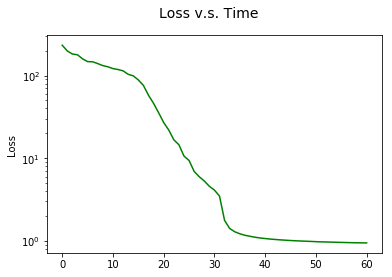

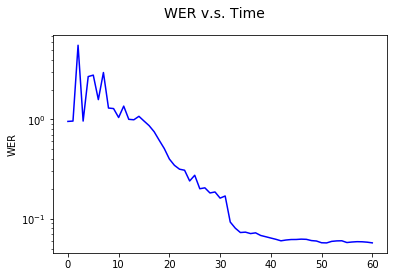

5.592309853877857


In [25]:
eps = list(range(opt_cfg["max_epochs"]))
'''
fig, ax1 = plt.subplots()
plt.suptitle("Loss & WER v.s. Time", fontsize=14)
ax2 = ax1.twinx()
ax1.plot(eps[:61], losses[:61], 'green')
ax2.plot(eps[:61], weres[:61], 'blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='green')
ax2.set_ylabel('WER', color='blue')
'''
plt.suptitle("Loss v.s. Time", fontsize = 14)
plt.plot(eps[:61], losses[:61], 'green')
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

plt.suptitle("WER v.s. Time", fontsize = 14)
plt.plot(eps[:61], weres[:61], 'blue')
plt.ylabel("WER")
plt.yscale("log")
plt.show()

In [14]:
#Testing

print("Testing RNN")
print("-------------")

test_model = torch.load(os.path.join(config["save_path"], "best"))
_, test_wer = evaluate(model, test_ldr, preproc, store_prediction=True, print_prediction=True)

print("{:.2f}% WER (test)".format(test_wer * 100.))

Testing RNN
-------------
True label:
  guo2 wu4 wei3 yuan2 jian1 guo2 wu4 yuan4 mi4 shu1 zhang3 luo2 gan4 min2 zheng4 bu4 bu4 zhang3 duo1 ji2 cai2 rang4 ye3 yi4 tong2 qian2 wang3 yan2 an1 kan4 wang4 ren2 min2 qun2 zhong4 
Predicted labal:
  guo2 wu4 wei3 yuan2 jian1 guo2 wu4 yuan4 mi4 shu1 zhang3 luo2 gan4 min2 zheng4 bu4 bu4 zhang3 duo1 ji2 cai2 rang4 ye3 yi4 tong2 qian2 wang3 yan2 an1 kan4 wang4 ren2 min2 qun2 zhong4 
True label:
  you2 tai4 yuan2 shi4 nan2 jiao1 qu1 kou4 zhuang1 cun1 nong2 min2 tou2 zi1 shu4 bai3 wan4 yuan2 jian4 she4 de5 ping2 yang2 ji2 mao4 shi4 chang3 yin1 guan2 li3 deng3 zhu1 fang1 mian4 de5 yuan2 yin1 yi3 ting2 ye4 yi4 nian2 
Predicted labal:
  you2 tai4 yuan2 shi4 nan2 jiao1 qu1 kou4 zhuang1 cun1 nong2 min2 tou2 zi1 shu4 bai3 wan4 yuan2 jian4 she4 de5 ping2 yang2 ji2 mao4 shi4 chang3 yin1 guan2 li3 deng3 zhu1 fang1 mian4 de5 yuan2 yin1 yi3 ting2 ye4 yi4 nian2 
True label:
  you2 lao3 ban4 fa3 zhong4 yu4 mi3 gai3 wei2 di4 mo2 yu4 mi3 he2 fei2 qiu2 yu4 miao2 ba

  jie4 shao4 xin4 yu3 wei3 tuo1 xie2 yi4 cong2 sheng1 huo2 xi3 di2 ji4 dao4 xiong2 mao1 nai2 fen3 mai2 xia4 song4 an4 ding4 shi2 zha4 dan4 
Predicted labal:
  ji1 shao4 xin4 yu3 wei3 tuo1 xie2 yi4 cong2 sheng1 huo2 xi3 di2 ji4 dao4 xiong2 mao1 nai2 fen3 mai2 xia4 song4 an4 ding4 shi2 zha4 dan4 
True label:
  yong4 ren2 dan1 wei4 yi1 ju4 qian2 kuan3 gui1 ding4 cai2 jian3 ren2 yuan2 zai4 liu4 ge5 yue4 nei4 lu4 yong4 ren2 yuan2 de5 ying1 dang1 you1 xian1 lu4 yong4 bei4 cai2 jian3 de5 ren2 yuan2 
Predicted labal:
  you3 ren2 dan1 wei4 yi1 ju4 qian2 kuan3 gui1 ding4 cai2 jian3 ren2 yuan2 zai4 liu4 ge5 yue4 nei4 lu4 yong4 ren2 yuan2 de5 ying1 dang1 you1 xian1 lu4 yong4 bei4 cai2 jian3 de5 ren2 yuan2 
True label:
  zhe4 wei4 bei4 hai2 zi5 men5 cheng1 wei2 zhang1 ye2 ye5 de5 ren2 jiao4 zhang1 yong3 liang4 shi4 shan1 dong1 sheng3 you1 xiu4 gong4 chan2 dang3 yuan2 ji3 ning2 shou4 yao4 chang3 chang2 zhang3 
Predicted labal:
  zhe4 lei4 bei4 hai2 zi5 men5 cheng1 wei2 zhang1 ye2 ye5 de5 ren2 jiao4 

  zhi2 gong1 men5 ai4 chang3 ai4 gang3 ai4 chan2 pin3 xin1 wang3 yi2 chu4 xiang3 jin4 er5 wang3 yi2 chu4 shi3 
True label:
  zhe4 zhong3 yi4 miao2 neng2 gou4 yu4 fang2 yang3 zhi2 de5 da4 ma3 ha1 yu2 he2 zun1 yu2 de5 jie1 bing4 yi4 miao2 de5 shi3 yong4 ke2 yi3 da4 da4 jian2 shao3 shui2 chan3 yang3 zhi2 ye4 zhong1 suo3 guang3 fan4 shi3 yong4 de5 kang4 jun3 su4 
Predicted labal:
  zhe4 zhong3 yi4 miao2 neng2 gou4 yu4 fang2 yang3 zhi2 de5 da4 ma3 ha1 yu2 he2 zun1 yu2 de5 jie1 bing4 yi4 miao2 de5 shi3 yong4 ke2 yi3 da4 da4 jian2 shao3 shui2 chan3 yang3 zhi2 ye4 zhong1 suo3 guang3 fan4 shi3 yong4 de5 kang4 jun3 su4 
True label:
  wei4 liao4 yue4 zou3 lu4 yue4 lan4 yue4 zou3 shan1 yue4 gao1 bu4 shao3 di4 fang1 shi4 bian1 tui1 che1 bian1 bu4 xing2 dao4 shen1 ye4 shi2 dian3 cai2 di3 da2 ba1 zhong1 
Predicted labal:
  wei4 liao4 yue4 zou3 lu4 yue4 lan4 yue4 zou3 shan1 yue4 gao1 bu4 shao3 di4 fang1 shi4 bian1 tui1 che1 bian1 bu4 xing2 dao4 shen1 ye4 shi2 dian3 cai2 di3 da2 ba1 zhong1 
True label:

  ta1 ren4 wei2 si1 chou2 zhi1 lu4 shang4 de5 min2 ge1 hen3 you3 te4 se4 yin1 wei4 de5 li3 wei4 zhi5 heng2 kua4 ou1 ya4 da4 lu4 shi4 ji2 te4 shu1 de5 kua4 guo2 ji2 min2 ge1 
Predicted labal:
  ta1 ren4 wei2 si1 chou2 zhi1 lu4 shang4 de5 min2 ge1 hen3 you3 te4 se4 yin1 wei4 de5 li3 wei4 zhi5 heng2 kua4 ou1 ya4 da4 lu4 shi4 ji2 te4 shu1 de5 kua4 guo2 ji2 min2 ge1 
True label:
  ya4 xiao1 an4 lei4 zai4 bian4 zhi4 de5 shi2 wu4 zhong1 han2 liang4 bi3 jiao4 duo1 suo2 yi3 ying1 shao3 chi1 xie1 yan1 rou4 yan1 cai4 xun1 yu2 zhi1 lei4 de5 shi2 pin3 
Predicted labal:
  ya4 er4 er4 mei2 gai4 ya4 que4 chi2 xiang1 fan3 de5 tai4 du5 suo2 yi3 ao4 en1 jiang1 jun1 ye3 shi4 dui4 ta1 huai2 hen4 zai4 xin1 
True label:
  dan4 bu2 yao4 dui4 ma3 dao3 yi4 yong1 er2 shang4 luan4 chao3 luan4 shuo1 fang2 zhi3 ji1 hua4 mao2 dun4 fa1 sheng1 yi4 wai4 chong1 tu1 
Predicted labal:
  dan4 bu2 yao4 dui4 ma3 dao3 yi4 yong1 er2 shang4 luan4 chao3 luan4 shuo1 fang2 zhi3 ji1 hua4 mao2 dun4 fa1 sheng1 yi4 wai4 chong1 tu1 
Tr

  jin4 ri4 wo3 xian4 nan2 he2 dian4 zhan4 ku4 qu1 yu2 lei4 da4 liang4 si3 wang2 yuan2 yin1 shi4 shang4 you2 bao3 kang1 xian4 pai2 fang4 de5 gong1 ye4 fei4 shui3 da4 liang4 liu2 ru4 
True label:
  ji3 ge4 yue4 qian2 e2 fang1 hai2 xuan1 bu4 jian2 shao3 dui4 ha1 yuan2 you2 de5 shu1 chu1 pei4 e2 yuan2 yin1 ju4 shuo1 shi4 ha1 de5 yuan2 you2 han2 za2 zhi4 tai4 duo1 
Predicted labal:
  ji3 ge4 yue4 qian2 e2 fang1 hai2 xuan1 bu4 jian2 shao3 dui4 ha1 yuan2 you2 de5 shu1 chu1 pei4 e2 yuan2 yin1 ju4 shuo1 shi4 ha1 de5 yuan2 you2 han2 za2 zhi4 tai4 duo1 
True label:
  zai4 qian2 yang2 xian4 nong2 min2 quan2 guo2 lao2 mo2 qin1 wan4 you3 de5 yuan2 yi4 chang3 kan4 dao4 si4 qian1 mu3 gan1 ju2 lin2 zai4 yan4 yang2 xia4 lv4 zhi1 yao2 ye4 xu2 bu4 zhang3 zan4 bu4 jue2 kou3 
Predicted labal:
  zai4 qian2 yang2 xian4 nong2 min2 quan2 guo2 lao2 mo2 qin1 wan4 you3 de5 yuan2 yi4 chang3 kan4 dao4 si4 qian1 mu3 gan1 ju2 lin2 zai4 yan4 yang2 xia4 lv4 zhi1 yao2 ye4 xu2 bu4 zhang3 zan4 bu4 jue2 kou3 
True label:
  

  you2 gou4 wu4 dao3 bao4 she4 yu3 bei3 jing1 ya3 meng4 ting2 zhuang1 shi4 gong1 si1 lian2 he2 chuang4 ban4 de5 hong2 mei2 gui1 you1 hui4 quan4 zhuan1 li4 jiang1 yu2 qi1 yue4 xia4 xun2 zai4 jing1 tui1 chu1 
Predicted labal:
  you2 gou4 wu4 dao3 bao4 she4 yu3 bei3 jing1 ya3 meng4 ting2 zhuang1 shi4 gong1 si1 lian2 he2 chuang4 ban4 de5 hong2 mei2 gui1 you1 hui4 quan4 zhuan1 li4 jiang1 yu2 qi1 yue4 xia4 xun2 zai4 jing1 tui1 chu1 
True label:
  jia4 ri4 ou3 you3 peng2 you5 yue1 fang3 wo3 men5 ye3 duo1 shang1 ding4 yu2 mou3 cha2 guan3 jian4 yue1 ji4 sheng3 jia1 ren2 ying4 chou5 you4 de2 shu1 xin1 huan2 jing4 
Predicted labal:
  jia4 yue4 e2 you3 peng2 you5 yue1 fang3 wo3 men5 ye3 duo1 shang1 ding4 yu2 mou3 cha2 guan3 jian4 yue1 ji4 sheng3 jia1 ren2 ying4 chou5 you4 de2 shu1 xin1 huan2 jing4 
True label:
  zhe4 xie1 dui4 hua4 huo4 za2 hua4 you3 chang2 you3 duan3 you3 ya3 you3 su2 you3 zhe2 you2 li3 you3 xue2 you3 shi2 ke3 ye2 you3 hun1 you3 su4 
Predicted labal:
  zhe4 xie1 dui4 hua4 huo4 za

  dan4 niang2 jia5 xiong1 di4 zi3 mei4 shi2 yi2 ge4 ta1 lao3 da4 cong2 xiao3 jiu4 gei3 jiu4 jia1 zuo4 yang2 nv3 gai3 ming2 lv3 ai4 zhi4 min3 nan2 hua4 shi4 ai4 di4 
True label:
  zhe4 ye3 nan2 guai4 gai1 chang3 yi3 zou2 ma3 deng1 shi4 de5 huan4 le5 shi2 ji3 wei4 chang2 zhang3 mei2 yi2 ge4 you3 neng2 nai5 ba3 chang3 zi5 zheng3 hao3 
Predicted labal:
  zhe4 ye3 nan2 guai4 gai1 chang3 yi3 zou2 ma3 deng1 shi4 de5 huan4 le5 shi2 ji3 wei4 chang2 zhang3 mei2 yi2 ge4 you3 neng2 nai5 ba3 chang3 zi5 zheng3 hao3 
True label:
  yu2 shi4 zhong1 qiu1 de5 you1 you1 yue4 se4 zhong1 bian4 you3 yi4 lv3 shu1 dan4 de5 xiang1 yun4 lv4 ying3 ying4 yi4 yu2 wo3 de5 ling2 hun2 wo3 de5 xin1 meng4 zhong1 
Predicted labal:
  yu2 shi4 zhong1 qiu1 de5 you1 you1 yue4 se4 zhong1 bian4 you3 yi4 lv3 shu1 dan4 de5 xiang1 yun4 lv4 ying3 ying4 yi4 yu2 wo3 de5 ling2 hun2 wo3 de5 xin1 meng4 zhong1 
True label:
  shou1 rong2 jiao4 yu5 suo3 ying1 dang1 shi2 xing2 wen2 ming2 guan2 li3 zu3 zhi1 bei4 shou1 rong2 jiao4 yu5 ren2 y

  zi4 cong2 you3 zhe4 gei3 xia1 zi5 zuo4 qie4 de5 hua4 ta1 kan4 jian4 jie1 shang5 de5 xia1 zi5 jiu4 you2 zhong3 yi4 yang4 de5 gan3 jue2 you4 tao3 yan4 you4 you2 dian3 pa4 
Predicted labal:
  zhe4 peng2 you5 ye3 xiang4 tan2 lian4 ai4 yi2 yang4 dei3 jiang3 yuan2 fen4 you3 yuan2 fen4 shi4 bu2 yong4 ke4 yi4 qu4 zhui1 qiu2 de5 
True label:
  shang4 deng3 tang2 guo3 xiang1 yan1 yao4 pin3 deng3 yong4 bo1 li5 zhi3 bao1 zhuang1 chu2 le5 mei3 guan1 wai4 hai2 you3 bao3 hu4 wu4 pin3 de5 jue2 miao4 zuo4 yong4 
Predicted labal:
  shang4 deng3 tang2 guo3 xiang1 yan1 yao4 pin3 deng3 yong4 bo1 li5 zhi3 bao1 zhuang1 chu2 le5 mei3 guan1 wai4 hai2 you3 bao3 hu4 wu4 pin3 de5 jue2 miao4 zuo4 yong4 
True label:
  zhi4 zhi3 zao3 hun1 zao3 yu4 he2 wei2 fan3 zheng4 ce4 de5 sheng1 yu4 nu3 li4 jian2 shao3 yi4 wai4 ren4 shen1 he2 ji4 hua4 wai4 sheng1 yu4 
Predicted labal:
  zhe4 zhi3 zao3 hun1 zao3 yu4 he2 wei2 fan3 zheng4 ce4 de5 sheng1 yu4 nu3 li4 jian2 shao3 yi4 wai4 ren4 shen1 he2 ji4 hua4 wai4 sheng1 yu4 
Tru

  suan1 tian2 ku3 la4 yi2 qie4 dou1 wu2 fa3 yong4 yu3 yan2 gai4 shu4 bu2 lun4 zen3 yang4 ta1 mei2 you3 tui4 suo1 ye3 mei2 you3 dao3 xia4 
True label:
  qi2 jian1 ta1 men5 zao1 yu3 lin2 yu4 bao4 shai4 zou3 de5 yao1 suan1 tui3 teng2 e4 le5 chi1 kou3 gan1 liang5 ke3 le5 he1 kou3 shan1 quan2 
Predicted labal:
  qi2 jian1 ta1 men5 zao1 yu3 lin2 yu4 bao4 shai4 zou3 de5 yao1 suan1 tui3 teng2 e4 le5 chi1 kou3 gan1 liang5 ke3 le5 he1 kou3 shan1 quan2 
True label:
  tong2 shi2 wei2 rao4 zhua1 yuan2 tou2 zhua1 pin2 zhong3 zhua1 fu2 wu4 zhua1 zhong4 dian3 zhua1 xuan1 chuan2 ji1 ji2 kai1 zhan3 gong1 zuo4 qu3 de2 jiao4 hao3 xiao4 guo3 
Predicted labal:
  tong2 shi2 wei2 rao4 zhua1 yuan2 tou2 zhua1 pin2 zhong3 zhua1 fu2 wu4 zhua1 zhong4 dian3 zhua1 xuan1 chuan2 ji1 ji2 kai1 zhan3 gong1 zuo4 qu3 de2 jiao4 hao3 xiao4 guo3 
True label:
  lao3 ren2 shuo1 dao4 zhe4 li3 you3 xie1 geng3 ye4 yi4 zhi2 zai4 yi4 pang2 pei2 zhe5 de5 er2 xi2 yan4 yan4 qiao1 qiao1 xiang4 wo3 di4 yan3 se4 wo3 ma3 shang4 shou1 zhu4 

  bi3 ang2 di2 huo4 ya4 jun1 cheng2 ji4 wei2 er4 shi2 er4 miao3 yi1 liu4 jia3 ge2 er3 ming2 lie4 di4 san1 cheng2 ji4 shi4 er4 shi2 er4 miao3 er4 ba1 
True label:
  zhe4 yang4 de5 qi3 ye4 suan4 bu5 suan4 neng2 shi4 ying4 shi4 chang3 jing1 ji4 suan4 bu5 suan4 you3 jing4 zheng1 li4 da2 an4 ying1 gai1 shi4 ken3 ding4 de5 
Predicted labal:
  zhe4 liang2 zhong3 qi3 ye4 suan4 bu5 suan4 neng2 shi4 ying4 shi4 chang3 jing1 ji4 suan4 bu5 suan4 you3 jing4 zheng1 li4 da2 an4 ying1 gai1 shi4 ken3 ding4 de5 
True label:
  ta1 dai4 biao3 e2 yu3 xue2 yuan4 xiang4 nai4 na4 fu1 ren5 zeng4 song4 le5 yi1 tao4 yu3 pu3 xi1 jin1 e2 yu3 xue2 yuan4 he2 bian1 de5 jiao4 cai2 dong1 fang1 e2 yu3 
Predicted labal:
  ta1 dai4 biao3 e2 yu3 xue2 yuan4 xiang4 nai4 na4 fu1 ren5 zeng4 song4 le5 yi1 tao4 yu3 pu3 xi1 jin1 e2 yu3 xue2 yuan4 he2 bian1 de5 jiao4 cai2 dong1 fang1 e2 yu3 
True label:
  xian1 shi4 yi4 qun2 zang4 ling2 yang2 lai2 qiao2 yi1 qiao2 jie1 zhe5 lang2 zou3 lai2 zhuan4 le5 yi1 quan1 hou4 lai2 xiong2 ye3 l

  ji3 chu4 ao4 kou3 bei4 zhan4 huo3 ran2 shao1 guo4 qing1 yan1 yi1 ran2 piao1 niao3 er2 sheng1 chao2 he2 gu3 shang4 kong1 mi2 san4 zhi2 dao4 yu3 tian1 di4 rong2 wei2 yi4 ti3 
True label:
  yi2 jin4 men2 wo3 bei4 jing1 dai1 le5 zhe4 hu4 ming2 jiao4 pang2 ji2 de5 lao3 nong2 shi4 kang4 mei3 yuan2 chao2 fu4 shang1 hui2 xiang1 de5 lao3 bing1 qi1 zi5 chang2 nian2 you3 bing4 jia1 tu2 si4 bi4 yi4 pin2 ru2 xi3 
Predicted labal:
  yi2 jin4 men2 wo3 bei4 jing1 dai1 le5 zhe4 hu4 ming2 jiao4 pang2 ji2 de5 lao3 nong2 shi4 kang4 mei3 yuan2 chao2 fu4 shang1 hui2 xiang1 de5 lao3 bing1 qi1 zi5 chang2 nian2 you3 bing4 jia1 tu2 si4 bi4 yi4 pin2 ru2 xi3 
True label:
  zou3 chu1 cun1 zi5 lao2 yuan3 lao2 yuan3 wo3 hai2 hui2 tou2 zhang1 wang4 na4 ge5 an1 ning2 tian2 jing4 de5 xiao3 yuan4 na4 ge5 shi3 wo3 zhong1 shen1 nan2 wang4 de5 xiao3 yuan4 
Predicted labal:
  zou3 chu1 cun1 zi5 lao2 yuan3 lao2 yuan3 wo3 hai2 hui2 tou2 zhang1 wang4 na4 ge5 an1 ning2 tian2 jing4 de5 xiao3 yuan4 na4 ge5 shi3 wo3 zhong1 shen1

  chang2 jiang1 hang2 wu4 guan2 li3 ju2 he2 chang2 jiang1 lun2 chuan2 zong3 gong1 si1 zui4 jin4 jue2 ding4 an1 pai2 yi4 bai3 san1 shi2 san1 sou1 ke4 lun2 ying2 jie1 chang2 jiang1 gan4 xian4 chun1 yun4 
True label:
  wang2 xian4 yu4 he2 zhi1 wei3 wang2 xian4 ben3 ting1 shuo1 lin2 jin4 he2 zhuang1 cun1 you3 ren2 yong4 da4 peng2 pei2 yu4 suan4 huang2 cheng2 gong1 jiu4 qu4 cai2 fang3 
Predicted labal:
  wang2 xian4 yu4 he2 zhi1 wei3 wang2 xian4 ben3 ting1 shuo1 lin2 jin4 he2 zhuang1 cun1 you3 ren2 yong4 da4 peng2 pei2 yu4 suan4 huang2 cheng2 gong1 jiu4 qu4 cai2 fang3 
True label:
  yin1 ci3 jia1 su4 nong2 cun1 zhong1 yi1 yao4 shi4 yong4 ren2 cai2 de5 pei2 yang3 shi4 jia1 qiang2 nong2 cun1 zhong1 yi1 yao4 gong1 zuo4 de5 yi2 ge4 zhan4 lve4 zhong4 dian3 
Predicted labal:
  yin1 ci3 jia1 su4 nong2 cun1 zhong1 yi1 yao4 shi4 yong4 ren2 cai2 de5 pei2 yang3 shi4 jia1 qiang2 nong2 cun1 zhong1 yi1 yao4 gong1 zuo4 de5 yi2 ge4 zhan4 lve4 zhong4 dian3 
True label:
  chu2 zi5 qi4 qi4 bi3 ao4 shou4 dao4 

  kuan1 kuo4 gui1 zheng3 de5 miao4 qian2 qu1 guang2 chang3 qing1 che4 ru2 jing4 de5 yin4 chi2 gu2 pu3 zhuang4 guan1 de5 xuan1 yuan2 qiao2 zai4 yi2 mian4 mian4 huang2 long2 qi2 ying4 chen4 xia4 xian3 de5 fen4 wai4 xiong2 wei3 zhuang1 yan2 
True label:
  shuo1 dao4 er4 mao2 qi3 ye4 ying1 gai1 xiang4 er4 mao2 na4 yang4 you3 zi1 jin1 you3 ji4 shu4 you3 yuan2 liao4 bao3 zheng4 you3 xiao1 shou4 qu2 dao4 you3 qi3 ye4 xing2 xiang4 
Predicted labal:
  shuo1 dao4 er4 mao2 qi3 ye4 ying1 gai1 xiang4 er4 mao2 na4 yang4 you3 zi1 jin1 you3 ji4 shu4 you3 yuan2 liao4 bao3 zheng4 you3 xiao1 shou4 qu2 dao4 you3 qi3 ye4 xing2 xiang4 
True label:
  ta1 men5 an4 di4 qu1 ba3 can2 jian3 gong4 ying4 gei3 sao1 si1 chang3 sao1 si1 chang3 dui4 jie1 zhi1 chou2 chang3 zhi1 chou2 chang3 dui4 kou3 yin4 ran2 chang3 
Predicted labal:
  ta1 men5 an4 di4 qu1 ba3 can2 jian3 gong4 ying4 gei3 sao1 si1 chang3 sao1 si1 chang3 dui4 jie1 zhi1 chou2 chang3 zhi1 chou2 chang3 dui4 kou3 yin4 ran2 chang3 
True label:
  shan1 lu4 dou

  liu2 yu4 sheng1 na4 chun2 cui4 de5 xia1 shuo1 you3 shi2 ye3 hui4 peng4 qiao3 yan2 zhong4 yin1 ci3 na4 shen2 xing4 jing4 ran2 yue4 chuan2 yue4 xuan2 hu5 
True label:
  yu2 shi4 zhong1 qiu1 de5 you1 you1 yue4 se4 zhong1 bian4 you3 yi4 lv3 shu1 dan4 de5 xiang1 yun4 lv4 ying3 ying4 yi4 yu2 wo3 de5 ling2 hun2 wo3 de5 xin1 meng4 zhong1 
Predicted labal:
  yu2 shi4 zhong1 qiu1 de5 you1 you1 yue4 se4 zhong1 bian4 you3 yi4 lv3 shu1 dan4 de5 xiang1 yun4 lv4 ying3 ying4 yi4 yu2 wo3 de5 ling2 hun2 wo3 de5 xin1 meng4 zhong1 
True label:
  nong2 min2 yu3 fa3 niu2 di3 jiao3 yang2 ken3 cao3 hao2 zi5 han1 han1 qun2 yu2 huan1 wu3 zhong4 ya1 xi1 dang4 
Predicted labal:
  nong2 min2 yu3 fa3 niu2 di3 jiao3 yang2 ken3 cao3 hao2 zi5 han1 han1 qun2 yu2 huan1 wu3 zhong4 ya1 xi1 dang4 
True label:
  bei3 jing1 shuang1 yu2 shu4 shang1 chang3 gui4 tai2 zu2 zhang3 deng4 chuan2 ying1 shuang1 an1 shang1 chang3 shou4 huo4 yuan2 feng2 ying3 dou1 shi4 cong2 gong1 chang3 diao4 ru4 shang1 ye4 zhan4 xian4 de5 
Predicted

  nan2 fang1 mou3 shi4 yi1 wei4 yu2 le4 ye4 lao2 ban3 cheng2 yi4 yao1 qing3 ying1 yun3 yi3 mei2 wan3 liang3 wan4 yuan2 de5 ju4 e2 chu1 chang3 fei4 qing3 ta1 wei4 yu2 le4 cheng2 zhu4 xing4 
True label:
  zhi2 dao3 yuan2 liu2 wen2 ge2 cheng2 ji1 shang4 qian2 jiang1 dai3 tu2 bao4 zhu4 wang2 yan4 dong4 yi2 xia4 zi5 zhua1 zhu4 dai3 tu2 bi2 shou3 de5 you4 bi4 liang3 ren2 he2 li4 jiang1 dai3 tu2 shuai1 dao3 zai4 di4 shang4 
Predicted labal:
  zhi2 dao3 yuan2 liu2 wen2 ge2 cheng2 ji1 shang4 qian2 jiang1 dai3 tu2 bao4 zhu4 wang2 yan4 dong4 yi2 xia4 zi5 zhua1 zhu4 dai3 tu2 bi2 shou3 de5 you4 bi4 liang3 ren2 he2 li4 jiang1 dai3 tu2 shuai1 dao3 zai4 di4 shang4 
True label:
  jian2 pu3 zhai4 fu4 zhu3 xi2 qiao2 sen1 pan1 jin1 tian1 xia4 wu3 dao4 da2 ya3 jia1 da2 shi2 shuo1 ya3 jia1 da2 hui4 yi5 neng2 fou3 qu3 de2 cheng2 guo3 jiang1 qu3 jue2 yu2 yue4 nan2 
Predicted labal:
  jian2 pu3 zhai4 fu4 zhu3 xi2 qiao2 sen1 pan1 jin1 tian1 xia4 wu3 dao4 da2 ya3 jia1 da2 shi2 shuo1 ya3 jia1 da2 hui4 yi5 neng2 f

  ta1 xiang3 zhong1 yi1 jiang3 yin1 yang2 tiao2 he2 yin1 yang2 bu4 xie2 tiao2 bu4 ping2 heng2 jiu4 hui4 sheng1 bing4 jian1 zhou1 yan2 ye3 shi4 ren2 ti3 nei4 bu4 xie2 tiao2 bu4 ping2 heng2 de5 biao3 xian4 
True label:
  bi3 sai4 cai3 yong4 shuang1 xun2 huan2 liang3 ju2 ji4 fen1 zhi4 zai4 shi2 lun2 gong4 ji4 er4 shi2 chang3 jiao4 liang5 zhong1 ding4 chu1 sheng4 fu4 de5 zhi2 you3 ba1 chang3 er2 shuang1 fang1 wo4 shou3 yan2 he2 de5 you3 shi2 er4 chang3 
Predicted labal:
  bi3 sai4 cai3 yong4 shuang1 xun2 huan2 liang3 ju2 ji4 fen1 zhi4 zai4 shi2 lun2 gong4 ji4 er4 shi2 chang3 jiao4 liang5 zhong1 ding4 chu1 sheng4 fu4 de5 zhi2 you3 ba1 chang3 er2 shuang1 fang1 wo4 shou3 yan2 he2 de5 you3 shi2 er4 chang3 
True label:
  zui4 hou4 an4 zhuan1 ye4 zu3 ye4 yu2 qing1 nian2 zu3 ye4 yu2 zhong1 lao3 nian2 zu3 fen1 bie2 chan3 sheng1 guan4 jun1 san1 ren2 ya4 jun1 liu4 ren2 ji4 jun1 jiu3 ren2 
Predicted labal:
  zui4 hou4 an4 zhuan1 ye4 zu3 ye4 yu2 qing1 nian2 zu3 ye4 yu2 zhong1 lao3 nian2 zu3 fen1 bie2 

  yang2 zhuo2 yong1 hu2 chou1 shui3 xu4 neng2 dian4 chang3 shi4 mu4 qian2 shi4 jie4 shang5 hai3 ba2 zui4 gao1 de5 chou1 shui3 xu4 neng2 dian4 chang3 ye3 shi4 xi1 zang4 zui4 da4 de5 neng2 yuan2 ji1 di4 
Predicted labal:
  yang2 zhuo2 yong1 hu2 chou1 shui3 xu4 neng2 dian4 chang3 shi4 mu4 qian2 shi4 jie4 shang5 hai3 ba2 zui4 gao1 de5 chou1 shui3 xu4 neng2 dian4 chang3 ye3 shi4 xi1 zang4 zui4 da4 de5 neng2 yuan2 ji1 di4 
True label:
  ben2 ban3 yi1 yi1 jiu3 er4 qi1 za2 wen2 shou4 hao3 ping2 yi4 wen2 nei4 huai2 bei3 wen2 lian2 ying1 wei2 huai2 nan2 wen2 lian2 te4 ci3 geng1 zheng4 
Predicted labal:
  dao1 ban3 yao1 bu4 yi3 jiu3 er4 qi1 za2 wen2 shou4 hao3 ping2 yi4 wen2 nei4 huai2 bei3 wen2 lian2 ying1 wei2 huai2 nan2 wen2 lian2 te4 ci3 geng1 zheng4 
True label:
  pao4 yan3 da2 hao3 le5 zha4 yao4 zen3 me5 zhuang1 yue4 zheng4 cai2 yao3 le5 yao3 ya2 shu1 de5 tuo1 qu4 yi1 fu5 guang1 bang3 zi5 chong1 jin4 le5 shui3 cuan4 dong4 
Predicted labal:
  pao4 yan3 da2 hao3 le5 zha4 yao4 zen3 me5 zhuang1

  na4 shi2 wo3 yi3 jing1 shang4 xue2 bang4 wan3 fang4 xue2 hou4 ting1 shuo1 lin2 cun1 you3 xi4 cao2 cao3 ba1 ji3 kou3 fan4 xin1 bian4 bei4 lin2 cun1 de5 luo2 gu3 sheng1 yin3 le5 qu4 
True label:
  feng1 ping2 lang4 jing4 de5 qi1 hei1 wu3 ye4 wang2 yun2 zhou1 wang2 xin1 huai2 wang2 yang2 zi5 shou3 xian1 fa1 xian4 guai4 wu5 shan3 zhe5 hong2 guang1 de5 yan3 jing5 
Predicted labal:
  feng1 ping2 lang4 jing4 de5 qi1 hei1 wu3 ye4 wang2 yun2 zhou1 wang2 xin1 huai2 wang2 yang2 zi5 shou3 xian1 fa1 xian4 guai4 wu5 shan3 zhe5 hong2 guang1 de5 yan3 jing5 
True label:
  dao3 shang5 chu2 le5 tu1 wu4 de5 lin2 xun2 jiao1 shi2 he2 wan1 yan2 tong1 you1 de5 xiao3 lu4 yi3 wai4 quan2 ran2 shi4 yi2 ge4 cao3 mu4 wei1 rui2 de5 lv4 se4 wang2 guo2 
Predicted labal:
  dao3 shang5 chu2 le5 tu1 wu4 de5 lin2 xun2 jiao1 shi2 he2 wan1 yan2 tong1 you1 de5 xiao3 lu4 yi3 wai4 quan2 ran2 shi4 yi2 ge4 cao3 mu4 wei1 rui2 de5 lv4 se4 wang2 guo2 
True label:
  fen3 sui4 si4 ren2 bang1 hou4 ren2 min2 wen2 xue2 chu1 ban3 she4 

  zhe4 ci4 da4 gui1 mo2 wu3 zhuang1 chong1 tu1 shi4 you2 yu2 kun1 sha1 bu4 dui4 shang4 yue4 qiang3 zhan4 wa3 zu2 si4 bai3 ying1 mu3 ying1 su4 di4 er2 yin2 qi3 de5 
Predicted labal:
  zhe4 ci4 da4 gui1 mo2 wu3 zhuang1 chong1 tu1 shi4 you2 yu2 kun1 sha1 bu4 dui4 shang4 yue4 qiang3 zhan4 wa3 zu2 si4 bai3 ying1 mu3 ying1 su4 di4 er2 yin2 qi3 de5 
True label:
  er4 lou4 yong4 duo1 yong4 dan1 ci2 zhong1 de5 zi4 mu3 huo4 zhe3 jiang1 dan1 ci2 zhong1 zi4 mu3 de5 shun4 xu4 gao3 cuo4 jiang1 xiang1 shi4 de5 zi4 mu3 yin4 cuo4 
Predicted labal:
  bao4 dao4 yao1 bu4 yong3 ding4 huo4 zhe3 ta1 zhe3 jiang1 biao3 shi4 zhi1 fu4 si4 zi4 zi4 mu3 huo4 ying2 zhe3 de5 zi4 mu3 de5 shun4 xu4 gao3 cuo4 jiang1 xiang1 shi4 de5 zi4 
True label:
  zai4 wo3 jia1 hei1 qu1 qu1 de5 lou2 qian2 ta1 xiang4 ye4 xing2 de5 mao1 yi2 yang4 shuang1 mu4 jiong2 jiong3 fa1 guang1 shang4 shen1 ting3 de5 bi3 zhi2 bu4 lv3 jiao3 jian4 
Predicted labal:
  zai4 wo3 jia1 hei1 qu1 qu1 de5 lou2 qian2 ta1 xiang4 ye4 xing2 de5 mao1 yi2 yang4 s

  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
Predicted labal:
  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
True label:
  ji3 nian2 qian2 wo3 zhong1 yu2 you3 ji1 hui4 dao4 le5 xiang4 wang3 yi3 jiu3 chong1 man3 meng4 huan4 se4 cai3 de5 a1 wa3 shan1 kao3 cha2 cang1 yuan2 ya2 hua4 
Predicted labal:
  ji3 nian2 qian2 wo3 zhong1 yu2 you3 ji1 hui4 dao4 le5 xiang4 wang3 yi3 jiu3 chong1 man3 meng4 huan4 se4 cai3 de5 a1 wa3 shan1 kao3 cha2 cang1 yuan2 ya2 hua4 
True label:
  zhuan1 ye4 xun2 hu1 wang3 zhong1 hua2 xun4 xun2 hu1 tai2 rong2 deng1 bang2 shou3 da4 zhang3 le5 zhuan1 ye4 xun2 hu1 wang3 de5 zhi4 qi5 he2 xing4 qu4 
Predicted labal:
  zhuan1 ye4 xun2 hu1 wang3 zhong1 hua2 xun4 xun2 hu1 tai2 rong2 deng1 bang2 shou3 da4 zhang3 le5 zhuan

  xin1 xue2 nian2 yi1 shi3 hu2 bei2 sheng3 yang2 xin1 xian4 wang2 ying1 xi1 wang4 xiao3 xue2 min2 ban4 jiao4 shi1 wang2 yue4 e2 hua2 zhe5 zhan3 xin1 de5 xiao3 mu4 chuan2 jie1 lai2 xue2 sheng1 shang4 xue2 
True label:
  te4 bie2 dui4 yin1 ya2 cao2 gu3 wei3 suo1 ya2 chuang2 di1 ping2 quan2 kou3 jia3 ya2 dai4 bu2 zhu4 zhe3 bang1 zhu4 zui4 wei2 ming2 xian3 
Predicted labal:
  te4 bie2 dui4 yin1 ya2 cao2 gu3 wei3 suo1 ya2 chuang2 di1 ping2 quan2 kou3 jia3 ya2 dai4 bu2 zhu4 zhe3 bang1 zhu4 zui4 wei2 ming2 xian3 
True label:
  zhe4 ye3 nan2 guai4 gai1 chang3 yi3 zou2 ma3 deng1 shi4 de5 huan4 le5 shi2 ji3 wei4 chang2 zhang3 mei2 yi2 ge4 you3 neng2 nai5 ba3 chang3 zi5 zheng3 hao3 
Predicted labal:
  zhe4 ye3 nan2 guai4 gai1 chang3 yi3 zou2 ma3 deng1 shi4 de5 huan4 le5 shi2 ji3 wei4 chang2 zhang3 mei2 yi2 ge4 you3 neng2 nai5 ba3 chang3 zi5 zheng3 hao3 
True label:
  bei3 jing1 shuang1 yu2 shu4 shang1 chang3 gui4 tai2 zu2 zhang3 deng4 chuan2 ying1 shuang1 an1 shang1 chang3 shou4 huo4 yuan2 feng2 

  ke3 shi4 yue4 quan2 shen3 pi1 zheng1 shao3 yong4 duo1 luan4 zhan4 lan4 yong4 geng1 di4 que4 yu4 yan3 yu4 lie4 
True label:
  you4 wa1 he2 cheng2 wa1 xi3 chi1 rou4 shi2 ke2 yi3 bu3 lao1 ying2 qu1 yang3 zhi2 qiu1 yin3 bu3 zhuo1 hai4 chong2 deng3 fang1 fa3 wei4 cheng2 wa1 ti2 gong4 shi2 liao4 
Predicted labal:
  you2 wa1 he2 cheng2 wa1 xi3 chi1 rou4 shi2 ke2 yi3 bu3 lao1 ying2 qu1 yang3 zhi2 qiu1 yin3 bu3 zhuo1 hai4 chong2 deng3 fang1 fa3 wei4 cheng2 wa1 ti2 gong4 shi2 liao4 
True label:
  ta1 de5 sang3 yin1 tian2 run4 qie3 yin1 yu4 kuan1 hou4 gao1 di1 zi4 ran2 yun4 yong4 zi4 ru2 bing4 you3 you1 mei3 de5 zhuang1 shi4 chan4 yin1 
Predicted labal:
  ta1 de5 sang3 yin1 tian2 run4 qie3 yin1 yu4 kuan1 hou4 gao1 di1 zi4 ran2 yun4 yong4 zi4 ru2 bing4 you3 you1 mei3 de5 zhuang1 shi4 chan4 yin1 
True label:
  xin1 xue2 nian2 yi1 shi3 hu2 bei2 sheng3 yang2 xin1 xian4 wang2 ying1 xi1 wang4 xiao3 xue2 min2 ban4 jiao4 shi1 wang2 yue4 e2 hua2 zhe5 zhan3 xin1 de5 xiao3 mu4 chuan2 jie1 lai2 xue2 sheng1

  huan4 ju4 hua4 shuo1 yi2 ge4 lv4 yuan2 zi3 zhi3 neng2 he2 yi2 ge4 na4 yuan2 zi3 jie2 he2 er2 er4 ge4 lv4 yuan2 zi3 cai2 neng2 he2 yi2 ge4 mei3 yuan2 zi3 hua4 he2 
Predicted labal:
  huan4 ju4 hua4 shuo1 yi2 ge4 lv4 yuan2 zi3 zhi3 neng2 he2 yi2 ge4 na4 yuan2 zi3 jie2 he2 er2 er4 ge4 lv4 yuan2 zi3 cai2 neng2 he2 yi2 ge4 mei3 yuan2 zi3 hua4 he2 
True label:
  lv3 yu3 you2 de5 shi2 jian1 bi3 wang3 wang3 lv2 chang2 you2 duan3 yu3 you2 ke4 de5 yuan4 wang5 xiang1 bei4 
Predicted labal:
  lv3 yu3 you2 de5 shi2 jian1 bi3 wang3 wang3 lv2 chang2 you2 duan3 yu3 you2 ke4 de5 yuan4 wang5 xiang1 bei4 
True label:
  nan2 bin1 yi2 ge4 zao3 shi2 wu3 yuan2 nv3 bin1 shi2 yuan2 chu2 le5 chi2 lin2 pen2 yu4 yi3 wai4 tong2 yang4 ke3 xiang3 yong4 sang1 na2 yu4 zheng1 qi4 yu4 
Predicted labal:
  nan2 bin1 yi2 ge4 zao3 shi2 wu3 yuan2 nv3 bin1 shi2 yuan2 chu2 le5 chi2 lin2 pen2 yu4 yi3 wai4 tong2 yang4 ke3 xiang3 yong4 sang1 na2 yu4 zheng1 qi4 yu4 
True label:
  zhe4 ci4 quan2 guo2 qing1 nian2 pai2 qiu2 lian2 s

  nong2 min2 quan1 di4 yang3 zhu1 wa1 tang2 yang3 yu2 kai1 shan1 zhong4 guo3 feng1 shan1 yu4 lin2 cong2 dan1 yi1 zhong4 yang3 xiang4 li4 ti3 yang3 zhi2 sheng1 tai4 nong2 ye4 mai4 jin4 
True label:
  jin4 lai2 yi1 xue2 jia1 you4 fa1 xian4 yin2 er3 duo1 tang2 you3 kang4 zhong3 liu2 de5 zuo4 yong4 zhe4 jiang1 wei4 yin2 er3 sheng1 chan3 kai1 chuang4 geng4 wei2 guang3 kuo4 de5 qian2 jing3 
Predicted labal:
  jin4 lai2 yi1 xue2 jia1 you4 fa1 xian4 yin2 er3 duo1 tang2 you3 kang4 zhong3 liu2 de5 zuo4 yong4 zhe4 jiang1 wei4 yin2 er3 sheng1 chan3 kai1 chuang4 geng4 wei2 guang3 kuo4 de5 qian2 jing3 
True label:
  tan2 dao4 di4 er4 jie1 duan4 tao2 tai4 sai4 wang2 da4 yong3 xi1 wang4 xian1 peng4 rui4 fa3 de2 deng3 ou1 zhou1 dui4 yin1 wei4 ta1 hen3 shu2 xi1 zhe4 xie1 dui4 
Predicted labal:
  tan2 dao4 di4 er4 jie1 duan4 tao2 tai4 sai4 wang2 da4 yong3 xi1 wang4 xian1 peng4 rui4 fa3 de2 deng3 ou1 zhou1 dui4 yin1 wei4 ta1 hen3 shu2 xi1 zhe4 xie1 dui4 
True label:
  ta1 yun4 yong4 yu4 xian3 xian1 an1 xi

  qu4 nian2 er4 yue4 wei4 man3 shi2 sui4 de5 xu2 min3 you4 bei4 shang4 hai3 qian2 jin4 ye4 yu2 jin4 xiu1 xue2 yuan4 lu4 qu3 ji4 xu4 xue2 xi2 xin1 gai4 nian4 ying1 yu3 di4 si4 ce4 
True label:
  ju4 jia1 na2 da4 guang3 bo1 gong1 si1 bao4 dao4 shuo1 jia1 na2 da4 yi4 sou1 wu3 zhuang1 xun2 luo2 ting3 jin1 tian1 bang4 wan3 yi3 jing1 chu1 hai3 shi2 wang3 da4 qian3 tan1 jin4 xing2 guan3 zhi4 
Predicted labal:
  ju4 jia1 na2 da4 guang3 bo1 gong1 si1 bao4 dao4 shuo1 jia1 na2 da4 yi4 sou1 wu3 zhuang1 xun2 luo2 ting3 jin1 tian1 bang4 wan3 yi3 jing1 chu1 hai3 shi2 wang3 da4 qian3 tan1 jin4 xing2 guan3 zhi4 
True label:
  ya4 xiao1 an4 lei4 zai4 bian4 zhi4 de5 shi2 wu4 zhong1 han2 liang4 bi3 jiao4 duo1 suo2 yi3 ying1 shao3 chi1 xie1 yan1 rou4 yan1 cai4 xun1 yu2 zhi1 lei4 de5 shi2 pin3 
Predicted labal:
  yao4 xiao1 an4 lei4 zai4 bian4 zhi4 de5 shi2 wu4 zhong1 han2 liang4 bi3 jiao4 duo1 suo2 yi3 ying1 shao3 chi1 xie1 yan1 rou4 yan1 cai4 xun1 yu2 zhi1 lei4 de5 shi2 pin3 
True label:
  shui3 kai1 le5 

  bi4 kai1 dui4 fang1 lei2 da2 zhui1 zong1 de5 mi4 jue2 zai4 yu2 zai4 ji1 ti3 shang4 pen1 tu2 de5 te4 shu1 tu2 liao4 er2 zhe4 zhong3 te4 shu1 tu2 liao4 shi4 ri4 ben3 yan2 zhi4 de5 
Predicted labal:
  bi4 kai1 dui4 fang1 lei2 da2 zhui1 zong1 de5 mi4 jue2 zai4 yu2 zai4 ji1 ti3 shang4 pen1 tu2 de5 te4 shu1 tu2 liao4 er2 zhe4 zhong3 te4 shu1 tu2 liao4 shi4 ri4 ben3 yan2 zhi4 de5 
True label:
  zhi3 yuan2 tu1 wei2 dao3 wu2 fang1 xiang1 jiang1 sun3 shi1 wei1 yi3 zun1 yi4 zheng4 que4 zuo4 jue2 ce4 yong2 meng3 fei1 sha1 qian1 gu3 song4 
Predicted labal:
  zhi3 yuan2 tu1 wei2 dao3 wu2 fang1 xiang1 jiang1 sun3 shi1 wei1 yi3 zun1 yi4 zheng4 que4 zuo4 jue2 ce4 yong2 meng3 fei1 sha1 qian1 gu3 song4 
True label:
  kai1 fa1 qu1 yi3 hang2 ye4 gui1 hua4 fen1 wei2 gong1 ye4 qu1 shang1 mao4 qu1 lv3 you2 qu1 sheng1 huo2 qu1 he2 gong1 gong4 jian4 zhu4 qu1 
Predicted labal:
  kai1 fa1 qu1 yi3 hang2 ye4 gui1 hua4 fen1 wei2 gong1 ye4 qu1 shang1 mao4 qu1 lv3 you2 qu1 sheng1 huo2 qu1 he2 gong1 gong4 jian4 zhu4 

  tong2 shi2 wei2 rao4 zhua1 yuan2 tou2 zhua1 pin2 zhong3 zhua1 fu2 wu4 zhua1 zhong4 dian3 zhua1 xuan1 chuan2 ji1 ji2 kai1 zhan3 gong1 zuo4 qu3 de2 jiao4 hao3 xiao4 guo3 
Predicted labal:
  tong2 shi2 wei2 rao4 zhua1 yuan2 tou2 zhua1 pin2 zhong3 zhua1 fu2 wu4 zhua1 zhong4 dian3 zhua1 xuan1 chuan2 ji1 ji2 kai1 zhan3 gong1 zuo4 qu3 de2 jiao4 hao3 xiao4 guo3 
True label:
  yong4 ren2 dan1 wei4 yi1 ju4 qian2 kuan3 gui1 ding4 cai2 jian3 ren2 yuan2 zai4 liu4 ge5 yue4 nei4 lu4 yong4 ren2 yuan2 de5 ying1 dang1 you1 xian1 lu4 yong4 bei4 cai2 jian3 de5 ren2 yuan2 
Predicted labal:
  you3 ren2 dan1 wei4 yi1 ju4 qian2 kuan3 gui1 ding4 cai2 jian3 ren2 yuan2 zai4 liu4 ge5 yue4 nei4 lu4 yong4 ren2 yuan2 de5 ying1 dang1 you1 xian1 lu4 yong4 bei4 cai2 jian3 de5 ren2 yuan2 
True label:
  hua2 guo4 yi1 quan1 you4 yi1 quan1 zhong1 yu2 you3 yi1 wei4 yun4 dong4 yuan2 ting2 xia4 lai5 jie1 guo4 ta1 song4 shang4 de5 shui3 bei1 le4 de5 ta1 you4 beng4 you4 tiao4 
Predicted labal:
  hua2 guo4 yi1 quan1 you4 yi1 q

  di4 yi1 pi1 shou1 ji2 de5 you3 xiang3 yu4 sheng3 gang3 ao4 he2 dong1 nan2 ya4 de5 ou1 yang2 shan1 chen2 can2 yun2 qin2 mu4 du4 ai1 huang2 qiu1 yun2 deng3 wu3 ren2 
True label:
  ta1 ceng2 wei4 huo3 yao4 cang1 ku4 yan2 jiu1 bi4 lei2 zhuang1 zhi4 wei4 guo2 jia1 zao4 bi4 chang3 yan2 jiu1 jian2 shao3 jin1 bi4 mo2 sun3 xiao1 hao4 de5 ban4 fa3 
Predicted labal:
  ta1 ceng2 wei4 huo3 yao4 cang1 ku4 yan2 jiu1 bi4 lei2 zhuang1 zhi4 wei4 guo2 jia1 zao4 bi4 chang3 yan2 jiu1 jian2 shao3 jin1 bi4 mo2 sun3 xiao1 hao4 de5 ban4 fa3 
True label:
  zui4 hou4 an4 zhuan1 ye4 zu3 ye4 yu2 qing1 nian2 zu3 ye4 yu2 zhong1 lao3 nian2 zu3 fen1 bie2 chan3 sheng1 guan4 jun1 san1 ren2 ya4 jun1 liu4 ren2 ji4 jun1 jiu3 ren2 
Predicted labal:
  zui4 hou4 an4 zhuan1 ye4 zu3 ye4 yu2 qing1 nian2 zu3 ye4 yu2 zhong1 lao3 nian2 zu3 fen1 bie2 chan3 sheng1 guan4 jun1 san1 ren2 ya4 jun1 liu4 ren2 ji4 jun1 jiu3 ren2 
True label:
  xuan3 yi4 ben3 hao3 shu1 shi3 ni3 li2 xiao3 yang4 er2 dun4 yu4 chu4 ni4 jing4 er2 bu4 nei3 chang

  ju4 jia1 na2 da4 guang3 bo1 gong1 si1 bao4 dao4 shuo1 jia1 na2 da4 yi4 sou1 wu3 zhuang1 xun2 luo2 ting3 jin1 tian1 bang4 wan3 yi3 jing1 chu1 hai3 shi2 wang3 da4 qian3 tan1 jin4 xing2 guan3 zhi4 
Predicted labal:
  ju4 jia1 na2 da4 guang3 bo1 gong1 si1 bao4 dao4 shuo1 jia1 na2 da4 yi4 sou1 wu3 zhuang1 xun2 luo2 ting3 jin1 tian1 bang4 wan3 yi3 jing1 chu1 hai3 shi2 wang3 da4 qian3 tan1 jin4 xing2 guan3 zhi4 
True label:
  ya4 xiao1 an4 lei4 zai4 bian4 zhi4 de5 shi2 wu4 zhong1 han2 liang4 bi3 jiao4 duo1 suo2 yi3 ying1 shao3 chi1 xie1 yan1 rou4 yan1 cai4 xun1 yu2 zhi1 lei4 de5 shi2 pin3 
Predicted labal:
  ya4 xiao1 an4 lei4 zai4 bian4 zhi4 de5 shi2 wu4 zhong1 han2 liang4 bi3 jiao4 duo1 suo2 yi3 ying1 shao3 chi1 xie1 yan1 rou4 yan1 cai4 xun1 yu2 zhi1 lei4 de5 shi2 pin3 
True label:
  niao2 niao3 de5 ta1 chui1 wo3 dao4 chen2 si3 de5 ye4 bang1 wo3 wang4 an1 jing4 de5 ling2 hun2 men5 zai4 
Predicted labal:
  niao2 niao3 de5 ta1 chui1 wo3 dao4 chen2 si3 de5 ye4 bang1 wo3 wang4 an1 jing4 de5 l

  chu2 le5 fu4 gei3 jiao4 shi1 men5 gong1 zi1 wai4 dai4 wei2 sen1 zi4 ji3 ze2 huo4 qu3 yi4 nian2 ba1 qian1 ying1 bang4 de5 shou1 ru4 
Predicted labal:
  chu2 le5 fu4 gei3 jiao4 shi1 men5 gong1 zi1 wai4 dai4 wei2 sen1 zi4 ji3 ze2 huo4 qu3 yi4 nian2 ba1 qian1 ying1 bang4 de5 shou1 ru4 
True label:
  bo2 lin2 ai4 le4 yue4 tuan2 zao3 qi1 gui1 ding4 zhi3 zhao1 shou1 ri4 er3 man4 ren2 ren4 wei2 ri4 er3 man4 ren2 sheng1 xing4 ping2 wen3 wu4 shi2 yi4 yu2 he2 zuo4 
Predicted labal:
  dao4 yan3 ai4 le4 yue4 tuan2 zao3 qi1 gui1 ding4 zhi3 zhao1 shou1 ri4 er3 man4 ren2 ren4 wei2 ri4 er3 man4 ren2 sheng1 xing4 ping2 wen3 wu4 shi2 yi4 yu2 he2 zuo4 
True label:
  zhe4 yi4 nian2 bei3 jing1 you2 piao4 chang3 yin1 yin4 bai2 qiu2 en1 zhe4 tao4 you2 piao4 er2 huo4 yin4 shua1 jiang3 
Predicted labal:
  zhe4 yi4 nian2 bei3 jing1 you2 piao4 chang3 yin1 yin4 bai2 qiu2 en1 zhe4 tao4 you2 piao4 er2 huo4 yin4 shua1 jiang3 
True label:
  fa3 yuan4 pan4 jue2 lian2 ying1 mei3 yue4 fu4 jia1 er2 yi4 bai3 yuan2 fu2 ya

  zhuan1 ye4 yin2 hang2 yao4 shi2 xian4 zi4 shen1 li4 yi4 bi4 xu1 yi3 zi1 jin1 chou2 cuo4 yu3 yun4 yong4 xiao4 yi4 de5 ti2 gao1 wei2 ji1 chu3 
Predicted labal:
  zhuan1 ye4 yin2 hang2 yao4 shi2 xian4 zi4 shen1 li4 yi4 bi4 xu1 yi3 zi1 jin1 chou2 cuo4 yu3 yun4 yong4 xiao4 yi4 de5 ti2 gao1 wei2 ji1 chu3 
True label:
  wan4 xian4 shi4 de5 mao2 jin1 chuang2 dan1 chang3 la1 si1 zhi4 ding1 chang3 ri4 hua4 chang3 deng3 er4 shi2 si4 jia1 qi3 ye4 yi3 xian1 hou4 wan2 cheng2 le5 ban1 qian1 
Predicted labal:
  wan4 xian4 shi4 de5 mao2 jin1 chuang2 dan1 chang3 la1 si1 zhi4 ding1 chang3 ri4 hua4 chang3 deng3 er4 shi2 si4 jia1 qi3 ye4 yi3 xian1 hou4 wan2 cheng2 le5 ban1 qian1 
True label:
  suan1 tian2 ku3 la4 yi2 qie4 dou1 wu2 fa3 yong4 yu3 yan2 gai4 shu4 bu2 lun4 zen3 yang4 ta1 mei2 you3 tui4 suo1 ye3 mei2 you3 dao3 xia4 
Predicted labal:
  suan1 tian2 ku3 la4 yi2 qie4 dou1 wu2 fa3 yong4 yu3 yan2 gai4 shu4 bu2 lun4 zen3 yang4 ta1 mei2 you3 tui4 suo1 ye3 mei2 you3 dao3 xia4 
True label:
  zai4 guo2 w

  zhong1 ao4 jing1 mao4 he2 zuo4 fa1 zhan3 ru2 ci3 zhi1 kuai4 ao4 fang1 reng2 gan3 bu4 zu2 ke3 jian4 ao4 zheng4 fu3 zhi4 ding4 rong2 ru4 ya4 zhou1 zhi1 ji2 qie4 
True label:
  bu4 jiu3 ou1 zhou1 quan2 wei1 yi1 xue2 za2 zhi4 ying1 guo2 xin1 zang4 za2 zhi4 quan2 wen2 kan1 deng1 le5 zhang1 yun4 de5 liang3 pian1 lun4 wen2 
Predicted labal:
  bu4 jiu3 ou1 zhou1 quan2 wei1 yi1 xue2 za2 zhi4 ying1 guo2 xin1 zang4 za2 zhi4 quan2 wen2 kan1 deng1 le5 zhang1 yun4 de5 liang3 pian1 lun4 wen2 
True label:
  ta1 shi4 li4 yong4 guang1 bo1 sao3 miao2 pei4 he2 ji1 guang1 guo4 lv4 yi3 hua4 xue2 wu4 xi1 qu4 zao4 mo2 zui4 hou4 yi3 yi1 zhong3 dian4 nao3 ji4 shu4 zhi4 zuo4 er2 cheng2 
Predicted labal:
  ta1 shi4 li4 yong4 guang1 bo1 sao3 miao2 pei4 he2 ji1 guang1 guo4 lv4 yi3 hua4 xue2 wu4 xi1 qu4 zao4 mo2 zui4 hou4 yi3 yi1 zhong3 dian4 nao3 ji4 shu4 zhi4 zuo4 er2 cheng2 
True label:
  ling4 wai4 jia1 gong1 xiu1 li3 he2 xiu1 pei4 ye4 wu4 bu4 shu3 yu2 ying2 ye4 shui4 de5 ying1 shui4 lao2 wu4 bu4 jiao3 na4 yin

  hu2 lao3 han4 ai4 shu1 ru2 ming4 nong2 xian2 shi2 zong3 ai4 zou3 cun1 chuan4 hu4 shui2 jia1 you3 shu1 bao4 ta1 jiu4 bao3 bei4 yi2 yang4 shou1 ji2 qi3 lai5 
Predicted labal:
  hu2 lao3 han4 ai4 shu1 ru2 ming4 nong2 xian2 shi2 zong3 ai4 zou3 cun1 chuan4 hu4 shui2 jia1 you3 shu1 bao4 ta1 jiu4 bao3 bei4 yi2 yang4 shou1 ji2 qi3 lai5 
True label:
  hu2 wen2 duo2 jiao4 shou4 ren4 wei2 mu4 qian2 you3 xie1 huan4 zhe3 yong4 yao4 cun2 zai4 wu4 qu1 ren4 wei2 jin4 kou3 yao4 cai2 neng2 zhi4 bing4 jia4 qian2 yue4 gui4 de5 yao4 xiao4 yue4 gao1 
Predicted labal:
  hu2 wen2 duo2 jiao4 shou4 ren4 wei2 mu4 qian2 you3 xie1 huan4 zhe3 yong4 yao4 cun2 zai4 wu4 qu1 ren4 wei2 jin4 kou3 yao4 cai2 neng2 zhi4 bing4 jia4 qian2 yue4 gui4 de5 yao4 xiao4 yue4 gao1 
True label:
  min2 yong4 hang2 kong1 qi4 di3 ya1 quan2 shi4 yong4 min2 yong4 hang2 kong1 qi4 guo2 ji2 deng1 ji4 guo2 fa3 lv4 
Predicted labal:
  min2 yong4 hang2 kong1 qi4 di3 ya1 quan2 shi4 yong4 min2 yong4 hang2 kong1 qi4 guo2 ji2 deng1 ji4 guo2 fa3 lv

  chen2 mu4 hua2 lv3 zheng4 cao1 xia4 yan3 ying4 yao1 dan1 ren4 ci3 ci4 huo2 dong4 de5 zong3 gu4 wen4 chen2 huang1 mei2 dan1 ren4 ping2 wei3 hui4 zhu3 ren4 
True label:
  yi1 jiu3 wu3 ling2 nian2 ba1 yue4 zhong1 yang1 ren2 min2 zheng4 fu3 zheng4 wu4 yuan4 ban1 bu4 le5 bao3 zhang4 fa1 ming2 quan2 yu3 zhuan1 li4 quan2 zan4 xing2 tiao2 li4 
Predicted labal:
  yi1 jiu3 wu3 ling2 nian2 ba1 yue4 zhong1 yang1 ren2 min2 zheng4 fu3 zheng4 wu4 yuan4 ban1 bu4 le5 bao3 zhang4 fa1 ming2 quan2 yu3 zhuan1 li4 quan2 zan4 xing2 tiao2 li4 
True label:
  ri4 ben3 dui4 zai4 nan2 zi3 tuan2 ti3 sai4 zhong1 huo4 yin2 pai2 dui4 yuan2 yan2 jing3 zhe2 xian2 zai4 ge4 ren2 quan2 neng2 sai4 ye3 duo2 de2 yi4 mei2 yin2 pai2 
Predicted labal:
  ri4 ben3 dui4 zai4 nan2 zi3 tuan2 ti3 sai4 zhong1 huo4 yin2 pai2 dui4 yuan2 yan2 jing3 zhe2 xian2 zai4 ge4 ren2 quan2 neng2 sai4 ye3 duo2 de2 yi4 mei2 yin2 pai2 
True label:
  yin2 hang2 cheng2 dui4 hui4 piao4 de5 cheng2 dui4 shen1 qing3 ren2 ying1 yu2 yin2 hang2 cheng2 dui4 h

  ju4 xi1 mei3 guo2 can1 yi4 yuan4 yi3 cao2 ni3 yi1 fen4 zhi1 chi2 ke4 lin2 dun4 xiang4 bo1 hei1 pai4 bing1 de5 jue2 yi4 an4 zhun3 bei4 zai4 ben3 yue4 shang4 xun2 jin4 xing2 biao3 jue2 
Predicted labal:
  ju4 xi1 mei3 guo2 can1 yi4 yuan4 yi3 cao2 ni3 yi1 fen4 zhi1 chi2 ke4 lin2 dun4 xiang4 bo1 hei1 pai4 bing1 de5 jue2 yi4 an4 zhun3 bei4 zai4 ben3 yue4 shang4 xun2 jin4 xing2 biao3 jue2 
True label:
  nian2 di3 mian2 fang3 yin4 ran2 chang3 niu3 kui1 wei2 ying2 bing4 shi2 xian4 li4 shui4 yi4 qian1 yi4 bai3 wan4 yuan2 cheng2 wei2 quan2 guo2 fang3 zhi1 hang2 ye4 niu3 kui1 zeng1 ying2 da4 hu4 
Predicted labal:
  nian2 di3 mian2 fang3 yin4 ran2 chang3 niu3 kui1 wei2 ying2 bing4 shi2 xian4 li4 shui4 yi4 qian1 yi4 bai3 wan4 yuan2 cheng2 wei2 quan2 guo2 fang3 zhi1 hang2 ye4 niu3 kui1 zeng1 ying2 da4 hu4 
True label:
  ai4 she4 sha2 bu4 zhi1 dao4 wai4 po2 tian1 tian1 shuo1 die1 shi4 hao3 ren2 shuo1 die1 shi4 jiao4 huai4 ren2 hai4 le5 shuo1 die1 yuan1 wang5 de5 hen3 
Predicted labal:
  ai4 she4 sh

  zhe4 yang4 de5 xiu1 yang3 de5 yan3 yuan2 ji2 shi3 zheng4 zou3 hong2 ye3 bu2 guo4 ru2 guo4 yan3 yun2 yan1 er2 yi3 cheng2 bu5 liao3 zhen1 zheng4 yi4 yi4 shang4 de5 yi4 shu4 jia1 
Predicted labal:
  zhe4 yang4 de5 xiu1 yang3 de5 yan3 yuan2 ji2 shi3 zheng4 zou3 hong2 ye3 bu2 guo4 ru2 guo4 yan3 yun2 yan1 er2 yi3 cheng2 bu5 liao3 zhen1 zheng4 yi4 yi4 shang4 de5 yi4 shu4 jia1 
True label:
  peng2 li4 yuan2 dong3 wen2 hua2 song4 zu3 ying1 yang2 hong2 ji1 mao2 ning2 yang2 yu4 ying2 deng3 yan3 yuan2 jiang1 deng1 tai2 xian4 yi4 
Predicted labal:
  peng2 li4 yuan2 dong3 wen2 hua2 song4 zu3 ying1 yang2 hong2 ji1 mao2 ning2 yang2 yu4 ying2 deng3 yan3 yuan2 jiang1 deng1 tai2 xian4 yi4 
True label:
  qin2 hua2 sun1 zhi3 chu1 wei4 le5 shi2 xian4 yin4 du4 yang2 he2 ping2 qu1 de5 mu4 biao1 xu1 yao4 qu1 yu4 nei4 bu4 he2 wai4 bu4 guo2 jia1 de5 gong4 tong2 nu3 li4 
Predicted labal:
  qin2 hua2 sun1 zhi3 chu1 wei4 le5 shi2 xian4 yin4 du4 yang2 he2 ping2 qu1 de5 mu4 biao1 xu1 yao4 qu1 yu4 nei4 bu4 he2 wai4 

  jin3 hui4 hua4 er2 lun4 qi2 bai2 shi2 shi4 wei1 wei1 kun1 lun2 ke3 zhe4 wei4 fu4 yong1 feng1 ya3 de5 men2 wai4 han4 lian2 yi2 kuai4 shi2 tou5 dou1 bu2 shi4 
Predicted labal:
  jin3 hui4 hua4 er2 lun4 qi2 bai2 shi2 shi4 wei1 wei1 kun1 lun2 ke3 zhe4 wei4 fu4 yong1 feng1 ya3 de5 men2 wai4 han4 lian2 yi2 kuai4 shi2 tou5 dou1 bu2 shi4 
True label:
  lu2 sen1 bao3 yi1 sheng1 jiao4 ren2 duan3 duan3 de5 a5 yi4 sheng1 ai4 er3 lan2 de5 ze2 yao4 ren2 chan4 zhe5 sang3 zi5 zuo4 a5 a5 a5 
Predicted labal:
  lu2 sen1 bao3 yi1 sheng1 jiao4 ren2 duan3 duan3 de5 a5 yi4 sheng1 ai4 er3 lan2 de5 ze2 yao4 ren2 chan4 zhe5 sang3 zi5 zuo4 a5 a5 a5 
True label:
  cun1 zhi1 bu4 shu1 ji5 ga1 ma3 luo2 bu4 shuo1 xue3 zai1 shi2 quan1 wo1 zhong4 de5 cao3 wei2 chi2 le5 yi2 ge4 ban4 yue4 fou3 ze2 sun3 shi1 geng4 da4 
Predicted labal:
  cun1 zhi1 bu4 shu1 ji5 ga1 ma3 luo2 bu4 shuo1 xue3 zai1 shi2 quan1 wo1 zhong4 de5 cao3 wei2 chi2 le5 yi2 ge4 ban4 yue4 fou3 ze2 sun3 shi1 geng4 da4 
True label:
  fa3 ji4 zan4 cheng2 b

  ta1 you4 han4 ri4 you4 shang4 pin1 ming4 yan3 ri4 shang4 you2 jian1 wan2 zhen1 xue2 zhe3 you4 chen2 jun4 tou2 chuang1 zi5 wu4 deng3 tou2 cheng2 zhe5 ren2 yin1 wang3 yu3 shang4 
True label:
  yi2 lu4 sheng1 jiang4 wan1 yan2 ru2 xing2 luan4 yun2 die2 lang4 zhi1 zhong1 na4 jiu3 shi5 qi1 mi3 gao1 de5 hua2 yan2 pu4 bu4 geng4 si4 chuan1 xue2 yu2 cui4 cong2 de5 yu4 lian4 
Predicted labal:
  yi2 lu4 sheng1 jiang4 wan1 yan2 ru2 xing2 luan4 yun2 die2 lang4 zhi1 zhong1 na4 jiu3 shi5 qi1 mi3 gao1 de5 hua2 yan2 pu4 bu4 geng4 si4 chuan1 xue2 yu2 cui4 cong2 de5 yu4 lian4 
True label:
  yong4 ren2 dan1 wei4 pin4 yong4 wai4 guo2 ren2 cong2 shi4 de5 gang3 wei4 ying1 shi4 you3 te4 shu1 xu1 yao4 guo2 nei4 zan4 que1 shi4 dang4 ren2 xuan3 qie3 bu4 wei2 fan3 guo2 jia1 you3 guan1 gui1 ding4 de5 gang3 wei4 
Predicted labal:
  yong4 ren2 dan1 wei4 pin4 yong4 wai4 guo2 ren2 cong2 shi4 de5 gang3 wei4 ying1 shi4 you3 te4 shu1 xu1 yao4 guo2 nei4 zan4 que1 shi4 dang4 ren2 xuan3 qie3 bu4 wei2 fan3 guo2 jia1 you3 gu

  su1 an1 ning2 sui4 ling4 sui2 cong2 jiao4 min2 tang2 qi3 yu2 peng2 ya4 chang1 deng3 jiang1 li3 yuan2 kang1 zhua1 zou3 
True label:
  ju4 yin4 du4 guan1 yuan2 tou4 lu4 shuang1 fang1 tao3 lun4 le5 yin4 du4 kong4 zhi5 de5 ke4 shi2 mi2 er3 di4 qu1 mu4 qian2 de5 jin3 zhang1 ju2 shi4 wen4 ti2 
Predicted labal:
  ju4 yin4 du4 guan1 yuan2 tou4 lu4 shuang1 fang1 tao3 lun4 le5 yin4 du4 kong4 zhi5 de5 ke4 shi2 mi2 er3 di4 qu1 mu4 qian2 de5 jin3 zhang1 ju2 shi4 wen4 ti2 
True label:
  po4 chan3 zhai4 wu4 wei2 po4 chan3 zhai4 hu4 suo2 you3 zhai4 quan2 ren2 de5 gong4 tong2 sun3 shi1 an4 zhai4 quan2 fa1 sheng1 e2 ping2 jun1 fen1 tan1 huo4 chong1 jian3 zhai4 quan2 
Predicted labal:
  po4 chan3 zhai4 wu4 wei2 po4 chan3 zhai4 hu4 suo2 you3 zhai4 quan2 ren2 de5 gong4 tong2 sun3 shi1 an4 zhai4 quan2 fa1 sheng1 e2 ping2 jun1 fen1 tan1 huo4 chong1 jian3 zhai4 quan2 
True label:
  bei4 lei2 ge1 wa3 zuo2 tian1 zai4 wai4 sheng3 cheng2 shi4 pu3 wa3 di4 ai1 de5 jing4 xuan3 ji2 hui4 shang5 cheng1 ou1 zhou1 ying

  yu2 mu4 zhai4 min2 su2 feng1 qing2 bie2 ju4 yi4 ge2 kai1 zhai4 men2 hun1 qu3 da3 san1 chao2 deng3 shi2 fen1 re4 nao5 ku1 jia4 tiao4 sang1 ji4 re4 nao5 you4 qi2 te4 
True label:
  wo3 de2 de5 yue4 shao3 dui4 lian2 meng2 yue4 you3 hao3 chu4 yin1 wei4 ta1 men5 ren4 wei2 wo3 huo4 xu3 hui4 gei3 xin1 jin4 qiu2 yuan2 kai1 xia4 e4 li4 
Predicted labal:
  wo3 de2 de5 yue4 shao3 dui4 lian2 meng2 yue4 you3 hao3 chu4 yin1 wei4 ta1 men5 ren4 wei2 wo3 huo4 xu3 hui4 gei3 xin1 jin4 qiu2 yuan2 kai1 xia4 e4 li4 
True label:
  tan1 wu1 nuo2 yong4 juan1 zeng4 zhen4 zai1 kuan3 wu4 shi4 chu4 fan4 fa3 lv4 xing2 wei2 yao4 an4 zhao4 xing2 fa3 di4 yi4 bai3 er4 shi2 liu4 tiao2 gui1 ding4 yan2 su4 chu2 li3 
Predicted labal:
  ta1 wu2 nuo2 yong4 juan1 zeng4 zhen4 zai1 kuan3 wu4 shi4 chu4 fan4 fa3 lv4 xing2 wei2 yao4 an4 zhao4 xing2 fa3 di4 yi4 bai3 er4 shi2 liu4 tiao2 gui1 ding4 yan2 su4 chu2 li3 
True label:
  feng1 lei2 jiao1 jia1 de5 yan2 han2 li3 wo3 jun1 ying1 yong3 pin1 sha1 you3 si4 ge4 ying2 gong1 ru4 ba

  ta1 shi4 yi1 zhu1 xiu4 mei3 ting3 ba2 ang2 yang2 de5 mu4 mian2 shu4 yin1 wei4 yong1 you3 xiang4 shu4 de5 ai4 qing2 he2 gao1 yuan3 de5 tian1 kong1 xian3 de5 ge2 wai4 mi2 ren2 
Predicted labal:
  ta1 shi4 yi1 zhu1 xiu4 mei3 ting3 ba2 ang2 yang2 de5 mu4 mian2 shu4 yin1 wei4 yong1 you3 xiang4 shu4 de5 ai4 qing2 he2 gao1 yuan3 de5 tian1 kong1 xian3 de5 ge2 wai4 mi2 ren2 
True label:
  si4 bai3 er4 shi2 san1 mi3 kua4 jing4 de5 zhu3 qiao2 he2 long2 wu4 cha1 bu4 zu2 liang3 hao2 mi3 bi3 xiao3 mi3 li4 hai2 xiao3 
Predicted labal:
  si4 bai3 er4 shi2 san1 mi3 kua4 jing4 de5 zhu3 qiao2 he2 long2 wu4 cha1 bu4 zu2 liang3 hao2 mi3 bi3 xiao3 mi3 li4 hai2 xiao3 
True label:
  yong4 chuan2 tong3 de5 chang2 gui1 yu4 yang1 fang1 shi4 mei3 yu4 yi1 mu3 yang1 miao2 zhi3 ke3 zai1 cha1 ba1 mu3 da4 tian2 di3 mo2 yu4 yang1 ze2 ke3 yi2 zai1 wu3 shi2 mu3 
Predicted labal:
  yang2 chan3 zhai4 wu4 wei2 po4 chan3 zhai4 hu4 suo2 you3 zhai4 quan2 ren2 de5 gong4 tong2 sun3 shi1 an4 zhai4 quan2 fa1 sheng1 e2 ping2 jun1

  nong2 ye4 yin2 hang2 jiang1 bei3 qu1 zhi1 hang2 zheng4 quan4 ye4 wu4 bu4 ye4 wu4 yuan2 xu2 yue4 lin2 yi3 dai4 mou2 si1 shou4 hui4 san1 shi2 yi2 wan4 yuan2 
True label:
  tong2 shi2 fen3 zhuang4 si4 liao4 ye3 yi3 bei4 ke1 li4 zhuang4 suo3 ti4 dai4 er2 wo3 guo2 nong2 cun1 reng2 zai4 shi3 yong4 ying2 yang3 jia4 zhi2 jiao4 di1 de5 hun4 he2 si4 liao4 
Predicted labal:
  tong2 shi2 fen3 zhuang4 si4 liao4 ye3 yi3 bei4 ke1 li4 zhuang4 suo3 ti4 dai4 er2 wo3 guo2 nong2 cun1 reng2 zai4 shi3 yong4 ying2 yang3 jia4 zhi2 jiao4 di1 de5 hun4 he2 si4 liao4 
True label:
  san3 wen2 shi4 po1 ju4 mei4 li4 de5 yi1 zhong3 wen2 ti3 yin1 qi2 zai4 yu3 yan2 wen2 cai3 yu3 gou4 si1 he2 yi4 jing4 shang4 de5 jiang3 qiu2 san3 wen2 you4 you3 mei3 wen2 zhi1 cheng1 
Predicted labal:
  san3 wen2 shi4 po1 ju4 mei4 li4 de5 yi1 zhong3 wen2 ti3 yin1 qi2 zai4 yu3 yan2 wen2 cai3 yu3 gou4 si1 he2 yi4 jing4 shang4 de5 jiang3 qiu2 san3 wen2 you4 you3 mei3 wen2 zhi1 cheng1 
True label:
  you2 wang2 zhen4 wang2 shou3 dao4 he4 bi

  yi2 ding4 hai2 you3 bie2 yang4 de5 sheng1 huo2 you3 cheng2 shi4 you3 yin1 yue4 you3 yao2 wang4 yuan3 fang1 shi4 wu4 de5 deng3 dai4 you3 ling4 ren2 kuang2 xi3 de5 fa1 xian4 
True label:
  tian1 gong1 bu4 zuo4 mei3 dang4 tian1 wan3 kai1 shi3 zhuan3 yin1 xia4 yu3 ci4 ri4 qing1 chen2 reng2 yin1 yun2 mi4 bu4 ren2 men5 ju3 sang4 de5 zhun3 bei4 che4 li2 
Predicted labal:
  tian1 gong1 bu4 zuo4 mei3 dang4 tian1 wan3 kai1 shi3 zhuan3 yin1 xia4 yu3 ci4 ri4 qing1 chen2 reng2 yin1 yun2 mi4 bu4 ren2 men5 ju3 sang4 de5 zhun3 bei4 che4 li2 
True label:
  kai1 fa1 qu1 yi3 hang2 ye4 gui1 hua4 fen1 wei2 gong1 ye4 qu1 shang1 mao4 qu1 lv3 you2 qu1 sheng1 huo2 qu1 he2 gong1 gong4 jian4 zhu4 qu1 
Predicted labal:
  kai1 fa1 qu1 yi3 hang2 ye4 gui1 hua4 fen1 wei2 gong1 ye4 qu1 shang1 mao4 qu1 lv3 you2 qu1 sheng1 huo2 qu1 he2 gong1 gong4 jian4 zhu4 qu1 
True label:
  zhe4 peng2 you5 ye3 xiang4 tan2 lian4 ai4 yi2 yang4 dei3 jiang3 yuan2 fen4 you3 yuan2 fen4 shi4 bu2 yong4 ke4 yi4 qu4 zhui1 qiu2 de5 
Predicted

  qing1 dai4 xue2 zhe3 cheng1 zhui1 wei2 zhong4 ni2 wen2 wang4 zhi1 long2 ze2 zai4 liu4 ji2 kong2 zi3 yin1 shou3 kai1 si1 xue2 zheng3 xiu1 gu3 ji2 shou1 tu2 jiang3 xue2 er2 cheng2 wan4 shi4 shi1 biao3 
Predicted labal:
  zhe4 xie1 xin1 xing2 tan4 ce4 yi2 qi4 shi4 you2 huai2 nan2 kuang4 ye4 xue2 yuan4 he2 chang2 sha1 xu4 hua2 yi2 biao2 chang3 gong4 tong2 yan2 zhi4 cheng2 gong1 de5 
True label:
  ting1 de5 chuang1 kou3 bei4 yong4 hei1 bu4 zhe1 de5 yan2 yan2 shi5 shi5 ting1 nei4 hun1 an4 meng2 long2 wei2 you3 ji3 chuan4 hong2 lv4 deng1 pin2 pin5 shan3 shuo4 
Predicted labal:
  ting1 de5 chuang1 kou3 bei4 yong4 hei1 bu4 zhe1 de5 yan2 yan2 shi5 shi5 ting1 nei4 hun1 an4 meng2 long2 wei2 you3 ji3 chuan4 hong2 lv4 deng1 pin2 pin5 shan3 shuo4 
True label:
  zhong1 wen2 wen2 ben3 wai4 wen2 wen2 ben3 fa1 sheng1 qi2 yi4 shi2 yi3 zhong1 wen2 wen2 ben3 wei2 zhun3 
Predicted labal:
  zhong1 wen2 wen2 ben3 wai4 wen2 wen2 ben3 fa1 sheng1 qi2 yi4 shi2 yi3 zhong1 wen2 wen2 ben3 wei2 zhun3 
True label:
  

  ta1 sui1 ran2 zi4 ji3 bing4 bu4 kan4 jian4 zhuang1 le5 zen3 yang4 de5 lian3 dan4 ci3 shi2 que4 jue2 de5 hen3 ju2 cu4 zui3 chun2 wei1 wei1 yi2 dong4 you4 yao2 yi5 yao2 tou2 
Predicted labal:
  tang2 xuan2 yuan2 si1 zhi1 an1 kai1 tai2 wan1 yin3 liao4 xiao1 shou4 e2 da2 wu3 yi4 mei3 yuan2 shi4 ge4 lei4 yin3 liao4 zhong1 zeng1 fu2 zui4 kuai4 de5 chan2 pin3 
True label:
  cong2 yan2 su4 gao1 ya3 de5 wen2 hua4 dao4 tong1 su2 de5 da4 zhong4 de5 wen2 hua4 cong2 yang2 chun1 bai2 xue3 dao4 xia4 li3 ba1 ren2 wo3 men5 dou1 bu2 yao4 hu1 shi4 
Predicted labal:
  cong2 yan2 su4 gao1 ya3 de5 wen2 hua4 dao4 tong1 su2 de5 da4 zhong4 de5 wen2 hua4 cong2 yang2 chun1 bai2 xue3 dao4 xia4 li3 ba1 ren2 wo3 men5 dou1 bu2 yao4 hu1 shi4 
True label:
  you3 de5 dan1 wei4 an4 nian2 ren2 jun1 yue4 shou1 ru4 jian3 qu4 fei4 yong4 ba1 bai3 yuan2 hou4 de5 yu2 e2 wei2 ying1 na4 shui4 suo3 de2 e2 
Predicted labal:
  you3 de5 dan1 wei4 an4 nian2 ren2 jun1 yue4 shou1 ru4 jian3 qu4 fei4 yong4 ba1 bai3 yuan2 hou4 de5 yu2 e

  zhen1 you1 mo4 na4 ji1 zhi4 bai3 bian4 na4 miao4 qu4 heng2 sheng1 rang4 ren2 yue4 zhuo2 mo2 yue4 peng3 fu4 er2 qie3 you3 mao2 se4 dun4 kai1 ban1 de5 qi3 wu4 
Predicted labal:
  zhen1 you1 mo4 na4 ji1 zhi4 bai3 bian4 na4 miao4 qu4 heng2 sheng1 rang4 ren2 yue4 zhuo2 mo2 yue4 peng3 fu4 er2 qie3 you3 mao2 se4 dun4 kai1 ban1 de5 qi3 wu4 
True label:
  jing1 ye4 zhong1 yi2 chuan2 sun3 shang1 jing1 zi3 de5 shui3 ping2 bing4 bu4 ying2 xiang3 sheng1 yu4 yi4 xie1 yi2 chuan2 sun3 shang1 ke2 yi3 zai4 shou4 yun4 hou4 zi4 ran2 xiu1 fu4 
Predicted labal:
  jing1 ye4 zhong1 yi2 chuan2 sun3 shang1 jing1 zi3 de5 shui3 ping2 bing4 bu4 ying2 xiang3 sheng1 yu4 yi4 xie1 yi2 chuan2 sun3 shang1 ke2 yi3 zai4 shou4 yun4 hou4 zi4 ran2 xiu1 fu4 
True label:
  xue4 ye4 xun2 huan2 xi4 tong3 you3 yan2 zhong4 zhang4 ai4 te4 bie2 shi4 na4 xie1 you2 yu2 nao3 xue4 guan3 bian4 zhai3 er2 jing1 chang2 tou2 yun1 tou2 hun1 de5 ren2 
Predicted labal:
  xue4 ye4 xun2 huan2 xi4 tong3 you3 yan2 zhong4 zhang4 ai4 te4 bie2 shi4 

  dang1 wo3 bing4 yu4 qu4 yi1 yuan4 kan4 wang4 nin2 shi2 nin2 zhe4 ge5 nian2 zhang2 zhe3 que4 tang3 zai4 bing4 chuang2 shang5 jin2 jin3 la1 zhe5 wo3 de5 shou3 yin1 yin1 zhu3 wo3 bao3 zhong4 
Predicted labal:
  dang1 wo3 bing4 yu4 qu4 yi1 yuan4 kan4 wang4 nin2 shi2 nin2 zhe4 ge5 nian2 zhang2 zhe3 que4 tang3 zai4 bing4 chuang2 shang5 jin2 jin3 la1 zhe5 wo3 de5 shou3 yin1 yin1 zhu3 wo3 bao3 zhong4 
True label:
  ke3 shi4 xiao3 pang4 zi5 ke3 bie2 sheng1 bing4 ba4 de5 biao3 niang2 de5 jie4 zhi5 quan2 dei3 zan4 ru4 dang4 pu4 er2 qie3 zhou4 ye4 chi1 bu4 hao3 shui4 bu4 an1 bu2 ya4 yu2 guo2 nan4 dang1 qian2 
Predicted labal:
  ke3 shi4 xiao3 pang4 zi5 ke3 bie2 sheng1 bing4 ba4 de5 biao3 niang2 de5 jie4 zhi5 quan2 dei3 zan4 ru4 dang4 pu4 er2 qie3 zhou4 ye4 chi1 bu4 hao3 shui4 bu4 an1 bu2 ya4 yu2 guo2 nan4 dang1 qian2 
True label:
  di2 que4 cong2 gu3 dao4 jin1 yin1 shuo1 jia3 hua4 shou4 chong3 sheng1 guan1 shuo1 zhen1 hua4 fan3 zao1 ya1 yi4 shen4 zhi4 diu1 guan1 diao4 nao3 dai5 de5 shi4 bu2 shen

  xia4 you2 yin4 niu2 shang4 you2 xi3 er3 ji2 ran2 ni3 yi3 zhi1 dao4 zi4 ji3 shuang1 er3 yi3 wu1 wei4 shen2 me5 you4 lai2 nong4 zang1 wo3 de5 niu2 kou3 
True label:
  zhe4 kuai4 shen2 qi2 de5 wo4 tu3 yang3 yu4 zhe5 qi1 shi5 wan4 qin2 lao2 zhi4 hui4 de5 ne4 he2 ren2 ye3 yang3 yu4 zhe5 wang2 rong2 sheng1 he2 ta1 de5 tong2 shi4 men5 
Predicted labal:
  zhe4 kuai4 shen2 qi2 de5 wo4 tu3 yang3 yu4 zhe5 qi1 shi5 wan4 qin2 lao2 zhi4 hui4 de5 ne4 he2 ren2 ye3 yang3 yu4 zhe5 wang2 rong2 sheng1 he2 ta1 de5 tong2 shi4 men5 
True label:
  ri4 ben3 yin2 hang2 wei4 le5 fang2 zhi3 wei3 zao4 zai4 piao4 mian4 shang5 cai2 qu3 le5 yan2 mi4 de5 fang2 wei3 cuo4 shi1 chao1 piao4 zhong1 hai2 han2 you3 ci2 xing4 gan3 ying4 cai2 liao4 
Predicted labal:
  ri4 ben3 yin2 hang2 wei4 le5 fang2 zhi3 wei3 zao4 zai4 piao4 mian4 shang5 cai2 qu3 le5 yan2 mi4 de5 fang2 wei3 cuo4 shi1 chao1 piao4 zhong1 hai2 han2 you3 ci2 xing4 gan3 ying4 cai2 liao4 
True label:
  ke3 shi4 xiang4 ta1 zhe4 yang4 de5 yi2 ge4 shu1 dai1 zi5 tu

  zhe4 wan3 li2 niang2 fan4 gu1 niang5 zai4 you3 li2 niang2 tong4 chu3 ye3 yao4 mei3 yang4 dou1 chi1 yi4 dian3 cai2 suan4 xun2 gui1 zun1 su2 de5 
Predicted labal:
  zhe4 wan3 li2 niang2 fan4 gu1 niang5 zai4 you3 li2 niang2 tong4 chu3 ye3 yao4 mei3 yang4 dou1 chi1 yi4 dian3 cai2 suan4 xun2 gui1 zun1 su2 de5 
True label:
  jin1 tian1 pei2 yi3 meng2 zhao3 feng2 bang1 zhao3 de5 you4 lei4 you4 e4 dan4 kan4 jian4 yi3 meng2 na4 fu4 zhao2 ji2 yang4 wo3 yi4 dian3 ye3 chi1 bu2 xia4 
Predicted labal:
  jin1 tian1 pei2 yi3 meng2 zhao3 feng2 bang1 zhao3 de5 you4 lei4 you4 e4 dan4 kan4 jian4 yi3 meng2 na4 fu4 zhao2 ji2 yang4 wo3 yi4 dian3 ye3 chi1 bu2 xia4 
True label:
  san1 shi4 yao4 xia4 jue2 xin1 dui4 yu4 suan4 wai4 zi1 jin1 jin4 xing2 qing1 li3 zheng3 dun4 ba3 ying1 na4 ru4 yu4 suan4 de5 yu4 suan4 wai4 zi1 jin1 dou1 na4 ru4 yu4 suan4 guan2 li3 
Predicted labal:
  san1 shi4 yao4 xia4 jue2 xin1 dui4 yu4 suan4 wai4 zi1 jin1 jin4 xing2 qing1 li3 zheng3 dun4 ba3 ying1 na4 ru4 yu4 suan4 de5 yu4 suan4

  qi2 zhong1 shui3 yun4 kou3 an4 ba1 shi2 yi2 ge4 kong1 yun4 kou3 an4 er4 shi2 wu3 ge4 tie3 lu4 kou3 an4 shi2 ge4 gong1 lu4 kou3 an4 er4 shi2 san1 ge5 
True label:
  liu2 ji1 song1 yuan2 shi4 qin1 zhou1 di4 qu1 de5 qin1 zhou1 shi4 zhang3 di4 qu1 che4 xian4 jian4 shi4 hou4 gai3 ren4 qin1 zhou1 shi4 de5 qin1 bei3 qu1 wei3 shu1 ji5 
Predicted labal:
  liu3 ji1 song1 yuan2 shi4 qin1 zhou1 di4 qu1 de5 qin1 zhou1 shi4 zhang3 di4 qu1 che4 xian4 jian4 shi4 hou4 gai3 ren4 qin1 zhou1 shi4 de5 qin1 bei3 qu1 wei3 shu1 ji5 
True label:
  wang1 jing1 wei4 yi4 xing2 ren2 dao4 le5 xiang1 gang3 wang1 fu1 fu4 lia3 yu3 chen2 gong1 bo2 deng3 dou1 shi4 guang3 dong1 ren2 you3 ge4 fu4 guan1 yu3 kuang4 yu4 min2 shi4 xiao3 tong2 xiang1 
Predicted labal:
  wang2 qin2 wei4 yi4 xing2 ren2 dao4 le5 xiang1 gang3 wang1 fu1 fu4 lia3 yu3 chen2 gong1 bo2 deng3 dou1 shi4 guang3 dong1 ren2 you3 ge4 fu4 guan1 yu3 kuang4 yu4 min2 shi4 xiao3 tong2 xiang1 
True label:
  nan2 sha1 zhi1 ye4 ta1 wang4 zhe5 yue4 se4 xia4 de5 bo1

  na4 zhong3 cong2 guo2 wai4 yin3 jin4 de5 yong4 la4 jiao1 jian3 fei2 de5 yang2 wan2 yi4 er5 jiu1 jing4 shi4 chi1 hai2 shi4 wai4 fu1 guang3 gao4 wei4 shuo1 ming2 bu4 de2 er2 zhi1 
Predicted labal:
  na4 zhong3 cong2 guo2 wai4 yin3 jin4 de5 yong4 la4 jiao1 jian3 fei2 de5 yang2 wan2 yi4 er5 jiu1 jing4 shi4 chi1 hai2 shi4 wai4 fu1 guang3 gao4 wei4 shuo1 ming2 bu4 de2 er2 zhi1 
True label:
  dang1 chuan2 wang3 xia4 piao1 shi2 bai2 chun2 lu4 yang2 qi3 si4 ti2 zai4 an4 bian1 zhui1 sui2 hao3 xiang4 shi4 song4 xing2 yi4 zhi2 pao3 le5 shi2 ji3 li3 tai4 qin1 qie4 le5 
Predicted labal:
  dang1 chuan2 wang3 xia4 piao1 shi2 bai2 chun2 lu4 yang2 qi3 si4 ti2 zai4 an4 bian1 zhui1 sui2 hao3 xiang4 shi4 song4 xing2 yi4 zhi2 pao3 le5 shi2 ji3 li3 tai4 qin1 qie4 le5 
True label:
  gai1 shu1 zhong4 dian3 jie4 shao4 le5 qi3 ye4 chou2 zi1 yu3 fu4 zhai4 jing1 ying2 zhui1 tao3 zhai4 wu4 yu3 yu4 fang2 zhai4 wu4 fa1 sheng1 de5 xiang1 guan1 zhi1 shi5 
Predicted labal:
  gai1 shu1 zhong4 dian3 jie4 shao4 le5 qi3 y

  ke3 shi4 qing1 chen2 mei3 dang1 mu4 song4 mai4 cai4 de5 nv3 er5 che3 zhe5 qing1 wu4 zou3 yuan3 shi2 ta1 you4 hui4 yi3 zhe5 cai4 an1 de5 men2 kuang4 tan4 xi1 
True label:
  qu3 yun2 xia2 wang2 yuan2 cui1 ying3 he2 liu2 dong1 zai4 xia4 wu3 de5 nv2 zi3 yi4 qian1 wu3 bai2 mi3 yu4 sai4 hou4 dou1 han4 liu2 man3 mian4 dan4 zong3 suan4 ji1 shen1 jue2 sai4 
Predicted labal:
  zhi4 yu2 ling3 wang2 yuan2 cui1 ying3 he2 liu2 dong1 zai4 xia4 wu3 de5 nv2 zi3 yi4 qian1 wu3 bai2 mi3 yu4 sai4 hou4 dou1 han4 liu2 man3 mian4 dan4 zong3 suan4 ji1 shen1 jue2 sai4 
True label:
  ji2 hui4 jie2 shu4 shi2 fen4 nu4 de5 ren2 qun2 chong1 xiang4 jie1 tou2 za2 chuang1 zi5 cui1 hui3 shang1 dian4 yu3 ya4 mei3 ni2 ya4 ren2 fa1 sheng1 ji1 lie4 chong1 tu1 
Predicted labal:
  ji2 hui4 jie2 shu4 shi2 fen4 nu4 de5 ren2 qun2 chong1 xiang4 jie1 tou2 za2 chuang1 zi5 cui1 hui3 shang1 dian4 yu3 ya4 mei3 ni2 ya4 ren2 fa1 sheng1 ji1 lie4 chong1 tu1 
True label:
  zhe4 wei4 bei4 hai2 zi5 men5 cheng1 wei2 zhang1 ye2 ye5 de5 ren2 

  you3 ci4 yu4 jing4 ran2 bi4 jing1 ban4 nian2 yu4 jing1 kong3 wan4 zhuang4 wo3 bu4 gan3 ken3 ding4 mo2 ca1 zhong1 mei2 you3 lou4 wang3 zhi1 yu2 ye3 huang2 huang2 bu4 ke3 zhong1 ri4 
True label:
  hu2 yong3 gui4 xian1 shi4 jiao3 hua2 di3 lai4 yi3 zi4 yuan4 jiao1 yi4 yuan4 da3 yuan4 ai2 wei2 you2 tuo1 yan2 ban4 an4 qi3 tu2 meng2 hun4 guo4 guan1 
Predicted labal:
  hu2 yong3 gui4 xian1 shi4 jiao3 hua2 di3 lai4 yi3 zi4 yuan4 jiao1 yi4 yuan4 da3 yuan4 ai2 wei2 you2 tuo1 yan2 ban4 an4 qi3 tu2 meng2 hun4 guo4 guan1 
True label:
  li3 bai2 xing2 yin2 tu2 miao2 hui4 tang2 chao2 shi1 ren2 li3 bai2 yang3 mian4 cang1 tian1 shi1 qing2 man3 huai2 yun4 si1 cuo4 ju4 shi2 xiao1 sa3 chao1 tuo1 de5 shen2 tai4 
Predicted labal:
  li3 bai2 xing2 yin2 tu2 miao2 hui4 tang2 chao2 shi1 ren2 li3 bai2 yang3 mian4 cang1 tian1 shi1 qing2 man3 huai2 yun4 si1 cuo4 ju4 shi2 xiao1 sa3 chao1 tuo1 de5 shen2 tai4 
True label:
  wang2 po2 kan4 yi5 kan4 ri4 wu3 le5 hai2 yao4 gan3 hui2 qu4 shao1 wu3 fan4 dan4 ren4 ta1 zen3

  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
Predicted labal:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
True label:
  zhong1 guo2 dui4 shou3 xian1 chu1 chang3 de5 shi4 lai4 ya4 wen2 sun1 yue4 li3 yan4 wu2 yong3 mei2 cui1 yong3 mei2 he2 he2 qi2 zhe4 ye3 shi4 shou2 xuan3 zhen4 rong2 
Predicted labal:
  zhong1 guo2 dui4 shou3 xian1 chu1 chang3 de5 shi4 lai4 ya4 wen2 sun1 yue4 li3 yan4 wu2 yong3 mei2 cui1 yong3 mei2 he2 he2 qi2 zhe4 ye3 shi4 shou2 xuan3 zhen4 rong2 
True label:
  nong2 min2 quan1 di4 yang3 zhu1 wa1 tang2 yang3 yu2 kai1 shan1 zhong4 guo3 feng1 shan1 yu4 lin2 cong2 dan1 yi1 zhong4 yang3 xiang4 li4 ti3 yang3 zhi2 sheng1 tai4 nong2 ye4 mai4 jin4 
Predicted labal:
  nong2 min2

  ji3 nian2 qian2 wo3 zhong1 yu2 you3 ji1 hui4 dao4 le5 xiang4 wang3 yi3 jiu3 chong1 man3 meng4 huan4 se4 cai3 de5 a1 wa3 shan1 kao3 cha2 cang1 yuan2 ya2 hua4 
True label:
  qu3 dai4 de5 duo1 shi4 gan4 min3 yue4 ming2 ci2 chang3 sheng1 chan3 de5 bao2 bai2 ci2 xiao3 bei1 xiao2 qiao3 ling2 long2 zhuang4 ru2 ban4 ge5 ping1 pang1 qiu2 da4 xiao3 san1 ge5 bei1 die2 qi3 ke3 han2 yu2 kou3 er2 bu2 lu4 
Predicted labal:
  qu3 dai4 de5 duo1 shi4 gan4 min3 yue4 ming2 ci2 chang3 sheng1 chan3 de5 bao2 bai2 ci2 xiao3 bei1 xiao2 qiao3 ling2 long2 zhuang4 ru2 ban4 ge5 ping1 pang1 qiu2 da4 xiao3 san1 ge5 bei1 die2 qi3 ke3 han2 yu2 kou3 er2 bu2 lu4 
True label:
  cong2 ci3 yin4 ran3 chang3 yi4 ju3 zai4 qi1 xia2 yang2 ming2 shi3 gui4 kai1 ye3 yin1 zhong4 yong4 neng2 ren2 er2 bei4 ren2 yu4 wei2 shi3 da4 dan3 
Predicted labal:
  cong2 ci3 yin4 ran3 chang3 yi4 ju3 zai4 qi1 xia2 yang2 ming2 shi3 gui4 kai1 ye3 yin1 zhong4 yong4 neng2 ren2 er2 bei4 ren2 yu4 wei2 shi3 da4 dan3 
True label:
  ling4 wai4 kuang4 qu

  jin4 ji3 nian2 bu2 dan4 wo3 yong4 shu1 gei2 nv3 er2 ya1 sui4 ye3 quan4 shuo1 qin1 peng2 bu2 yao4 gei2 nv3 er2 ya1 sui4 qian2 er2 gai3 song4 ya1 sui4 shu1 
True label:
  hu4 wai4 de5 sheng1 yin1 you3 yuan3 you3 jin4 shi2 fen1 cao2 za2 ke3 lai2 dao4 ta1 wu1 nei4 shi2 dan1 diao4 cheng2 weng1 weng5 sheng1 
Predicted labal:
  hu4 wai4 de5 sheng1 yin1 you3 yuan3 you3 jin4 shi2 fen1 cao2 za2 ke3 lai2 dao4 ta1 wu1 nei4 shi2 dan1 diao4 cheng2 weng1 weng5 sheng1 
True label:
  gai1 zhen4 mou3 cun1 ban4 zhi3 xiang1 chang3 qu4 nian2 chun1 tian1 shi1 huo3 sui1 sun3 shi1 can3 zhong4 dan4 yin1 wei4 ban4 bao2 xian3 kao4 cun1 min2 juan1 kuan3 cai2 du4 guo4 nan2 guan1 
Predicted labal:
  gai1 zhen4 mou3 cun1 ban4 zhi3 xiang1 chang3 qu4 nian2 chun1 tian1 shi1 huo3 sui1 sun3 shi1 can3 zhong4 dan4 yin1 wei4 ban4 bao2 xian3 kao4 cun1 min2 juan1 kuan3 cai2 du4 guo4 nan2 guan1 
True label:
  su1 zhou1 ben3 di4 de5 miao4 guan4 jiu4 hen3 duo1 ding4 hui4 si4 xuan2 miao4 guan4 tao2 hua1 an1 hai2 you3 na4 ling4 

  guo2 wai4 you3 guan1 zhuan1 jia1 diao4 cha2 le5 san1 bai3 duo1 ming2 chang2 shou4 zhe3 ren4 wei2 qin2 yu2 yong4 nao3 ke3 yan2 huan3 shuai1 lao3 er2 lan3 duo4 ke3 shi3 ren2 zao3 shuai1 
Predicted labal:
  guo2 wai4 you3 guan1 zhuan1 jia1 diao4 cha2 le5 san1 bai3 duo1 ming2 chang2 shou4 zhe3 ren4 wei2 qin2 yu2 yong4 nao3 ke3 yan2 huan3 shuai1 lao3 er2 lan3 duo4 ke3 shi3 ren2 zao3 shuai1 
True label:
  jian4 yuan2 zhi4 jin1 yi2 you3 lu4 da4 er3 yang2 kong3 que4 deng3 zai4 zhe4 li3 sheng1 er2 yu4 nv3 liang3 qian1 duo1 tou2 
Predicted labal:
  jie3 yuan2 zhi4 jin1 yi2 you3 lu4 da4 er3 yang2 kong3 que4 deng3 zai4 zhe4 li3 sheng1 er2 yu4 nv3 liang3 qian1 duo1 tou2 
True label:
  cun1 li3 de5 lao3 nian2 ren2 duan1 ran2 su4 ran2 de5 jiu1 zheng4 zhe5 wai4 xiang1 ren2 de5 fa1 yin1 guo4 hou4 hai2 bian1 yao2 tou2 bian1 gan3 tan4 shuo1 wai4 xiang1 ren2 jiu4 shi5 ben4 
Predicted labal:
  cun1 li3 de5 lao3 nian2 ren2 duan1 ran2 su4 ran2 de5 jiu1 zheng4 zhe5 wai4 xiang1 ren2 de5 fa1 yin1 guo4 hou4 ha

  jiang1 xi1 hu2 kou3 xian4 shuang1 zhong1 shui2 chan3 chang3 yu2 min2 zhang1 hou4 yu2 ri4 qian2 jiang1 yi1 tiao2 bu3 huo4 ru4 wang3 de5 xing2 si4 bian1 yu2 de5 yan1 zhi5 yu2 fang4 hui2 jiang1 zhong1 
True label:
  xie4 jin4 heng2 tong1 ying3 ye4 gong1 si1 yi3 zhong1 guo2 ben2 tu3 dian4 ying3 wei2 li4 shen1 zhi1 ben3 yi3 pai1 she4 pin3 wei2 gao1 yi4 shu4 xing4 qiang2 de5 ying3 pian4 wei2 mu4 biao1 
Predicted labal:
  xie4 jin4 heng2 tong1 ying3 ye4 gong1 si1 yi3 zhong1 guo2 ben2 tu3 dian4 ying3 wei2 li4 shen1 zhi1 ben3 yi3 pai1 she4 pin3 wei2 gao1 yi4 shu4 xing4 qiang2 de5 ying3 pian4 wei2 mu4 biao1 
True label:
  lu2 tai4 yu2 yin1 fan4 you3 zhu3 dong4 can1 yu4 jun1 shi4 pan4 luan4 he2 nei4 luan4 zui4 mou2 sha1 shang4 si5 wei4 sui4 zui4 ji2 shou4 hui4 zui4 deng3 bei4 pan4 chu3 wu2 qi1 tu2 xing2 
Predicted labal:
  lu2 tai4 yu2 yin1 fan4 you3 zhu3 dong4 can1 yu4 jun1 shi4 pan4 luan4 he2 nei4 luan4 zui4 mou2 sha1 shang4 si5 wei4 sui4 zui4 ji2 shou4 hui4 zui4 deng3 bei4 pan4 chu3 wu2 qi1 

  cong2 ya1 pian4 zhan4 zheng1 dao4 qing1 zheng4 fu3 kua3 tai2 jin3 dui4 wai4 pei2 kuan3 yi2 xiang4 lei3 ji4 jiang1 jin4 bai2 yin2 shi2 san1 yi4 liang3 
True label:
  shan1 dong1 sheng3 yan1 tai2 ao4 er3 hu1 si1 yao4 ye4 you3 xian4 gong1 si1 jin4 ri4 yan2 zhi4 cheng2 gong1 wai4 yong4 jiang4 xue4 ya1 xin1 yao4 li4 ya1 ping2 shuang1 
Predicted labal:
  fen1 dong1 sheng3 yan1 tai2 ao4 er3 hu1 si1 yao4 ye4 you3 xian4 gong1 si1 jin4 ri4 yan2 zhi4 cheng2 gong1 wai4 yong4 jiang4 xue4 ya1 xin1 yao4 li4 ya1 ping2 shuang1 
True label:
  shou4 xun1 yi2 shi4 jin1 tian1 zai4 zha1 yi1 er3 wai4 jiao1 bu4 ju3 xing2 en1 ke1 lv3 fa3 jiang1 jun1 dai4 biao3 meng2 bo2 tuo1 xiang4 an1 guo2 zheng4 shou4 xun1 
Predicted labal:
  shou4 xun1 yi2 shi4 jin1 tian1 zai4 zha1 yi1 er3 wai4 jiao1 bu4 ju3 xing2 en1 ke1 lv3 fa3 jiang1 jun1 dai4 biao3 meng2 bo2 tuo1 xiang4 an1 guo2 zheng4 shou4 xun1 
True label:
  hang2 cheng2 mou3 si1 zhi1 chang3 yi1 wei4 shen3 xing4 gu1 niang5 huai2 chuai1 yi4 qian1 duo1 yuan2 qian2 la

  si4 shi4 dui4 quan2 ti3 yuan2 gong1 jia1 qiang2 wai4 yu3 pei2 xun4 yan2 ge2 wai4 yu3 kao3 shi4 bing4 ba3 wai4 yu3 cheng2 ji4 he2 ben3 ren2 de5 jing1 ji4 shou1 ru4 gua4 gou1 
Predicted labal:
  si4 shi4 dui4 quan2 ti3 yuan2 gong1 jia1 qiang2 wai4 yu3 pei2 xun4 yan2 ge2 wai4 yu3 kao3 shi4 bing4 ba3 wai4 yu3 cheng2 ji4 he2 ben3 ren2 de5 jing1 ji4 shou1 ru4 gua4 gou1 
True label:
  nan2 jing1 xuan2 wu3 hu2 dong4 wu5 yuan2 li3 de5 yi2 dui4 hong2 xing1 xing5 xue2 hui4 le5 xiang4 you2 ren2 zuo4 guai4 dong4 zuo4 he2 tu3 tuo4 mo5 deng3 huai4 mao2 bing5 chang2 chang2 nong4 de5 you2 ren2 sao3 xing4 er2 gui1 
Predicted labal:
  nan2 jing1 xuan2 wu3 hu2 dong4 wu5 yuan2 li3 de5 yi2 dui4 hong2 xing1 xing5 xue2 hui4 le5 xiang4 you2 ren2 zuo4 guai4 dong4 zuo4 he2 tu3 tuo4 mo5 deng3 huai4 mao2 bing5 chang2 chang2 nong4 de5 you2 ren2 sao3 xing4 er2 gui1 
True label:
  dai4 ye4 wan3 jian4 shen1 yue4 chu1 yu2 dong1 shan1 rong2 rong5 yue4 hua2 ca1 liang4 xiao3 hu2 ying4 ru4 shui3 zhong1 de5 yue4 hui1 ru2 

  zhi2 ci3 hua4 ruo4 gu4 qu4 yi4 zhou1 nian2 zhi1 ji4 wo3 xie3 ci3 xiao3 wen2 zhui1 yi4 wo3 men5 jiao1 wang3 de5 ji3 jian4 shi4 yi3 ji4 ai1 si1 
Predicted labal:
  zhi2 ci3 hua4 ruo4 gu4 qu4 yi4 zhou1 nian2 zhi1 ji4 wo3 xie3 ci3 xiao3 wen2 zhui1 yi4 wo3 men5 jiao1 wang3 de5 ji3 jian4 shi4 yi3 ji4 ai1 si1 
True label:
  jing1 cha2 ming2 mo4 yong3 ji4 gong4 fei1 fa3 yin4 shua1 tu2 shu1 yi4 bai2 wu3 shi2 si4 zhong3 jin4 er4 bai3 ling2 si4 wan4 ce4 fei1 fa3 jing1 ying2 e2 da2 er4 bai3 er4 shi5 ba1 wan4 duo1 yuan2 
Predicted labal:
  jing1 cha2 ming2 mo4 yong3 ji4 gong4 fei1 fa3 yin4 shua1 tu2 shu1 yi4 bai2 wu3 shi2 si4 zhong3 jin4 er4 bai3 ling2 si4 wan4 ce4 fei1 fa3 jing1 ying2 e2 da2 er4 bai3 er4 shi5 ba1 wan4 duo1 yuan2 
True label:
  guo2 wu4 yuan4 chu1 yu2 an1 quan2 kao3 lv4 mei2 you3 tou4 lu4 shui2 jiang1 qian2 wang3 ka1 bu4 er3 ye3 bu2 tou4 lu4 zhe4 wei4 wai4 jiao1 guan1 jiang1 cong2 he2 di4 chu1 fa1 
Predicted labal:
  guo2 wu4 yuan4 chu1 yu2 an1 quan2 kao3 lv4 mei2 you3 tou4 lu4 s

  ke3 shi4 qing1 chen2 mei3 dang1 mu4 song4 mai4 cai4 de5 nv3 er5 che3 zhe5 qing1 wu4 zou3 yuan3 shi2 ta1 you4 hui4 yi3 zhe5 cai4 an1 de5 men2 kuang4 tan4 xi1 
Predicted labal:
  ke3 shi4 qing1 chen2 mei3 dang1 mu4 song4 mai4 cai4 de5 nv3 er5 che3 zhe5 qing1 wu4 zou3 yuan3 shi2 ta1 you4 hui4 yi3 zhe5 cai4 an1 de5 men2 kuang4 tan4 xi1 
True label:
  qu3 yun2 xia2 wang2 yuan2 cui1 ying3 he2 liu2 dong1 zai4 xia4 wu3 de5 nv2 zi3 yi4 qian1 wu3 bai2 mi3 yu4 sai4 hou4 dou1 han4 liu2 man3 mian4 dan4 zong3 suan4 ji1 shen1 jue2 sai4 
Predicted labal:
  qu3 yun2 xia2 wang2 yuan2 cui1 ying3 he2 liu2 dong1 zai4 xia4 wu3 de5 nv2 zi3 yi4 qian1 wu3 bai2 mi3 yu4 sai4 hou4 dou1 han4 liu2 man3 mian4 dan4 zong3 suan4 ji1 shen1 jue2 sai4 
True label:
  ji2 hui4 jie2 shu4 shi2 fen4 nu4 de5 ren2 qun2 chong1 xiang4 jie1 tou2 za2 chuang1 zi5 cui1 hui3 shang1 dian4 yu3 ya4 mei3 ni2 ya4 ren2 fa1 sheng1 ji1 lie4 chong1 tu1 
Predicted labal:
  ji2 hui4 jie2 shu4 shi2 fen4 nu4 de5 ren2 qun2 chong1 xiang4 jie1 tou2 

  nan2 bin1 yi2 ge4 zao3 shi2 wu3 yuan2 nv3 bin1 shi2 yuan2 chu2 le5 chi2 lin2 pen2 yu4 yi3 wai4 tong2 yang4 ke3 xiang3 yong4 sang1 na2 yu4 zheng1 qi4 yu4 
True label:
  liu2 shou4 chun1 jue2 chu1 ang1 zang1 de5 jian1 xu1 wang4 ji4 ba3 tun1 yan1 de5 shou3 shou1 xia4 lai5 yong4 dai1 dun4 de5 yan3 jing5 wang4 zhe5 ta1 
Predicted labal:
  liu4 shou3 yong4 jue2 chu1 ang1 zang1 de5 jian1 xu1 wang4 ji4 ba3 tun1 yan1 de5 shou3 shou1 xia4 lai5 yong4 dai1 dun4 de5 yan3 jing5 wang4 zhe5 ta1 
True label:
  zhe4 yi1 chang4 yi4 de2 dao4 le5 cong2 shi4 lin2 chuang2 yi1 xue2 de5 er4 shi2 ba1 wei4 zhong1 guo2 gong1 cheng2 yuan4 yuan4 shi4 zhong1 guo2 ke1 xue2 yuan4 yuan4 shi4 de5 qian1 ming2 zan4 tong2 
Predicted labal:
  zhe4 yi1 chang4 yi4 de2 dao4 le5 cong2 shi4 lin2 chuang2 yi1 xue2 de5 er4 shi2 ba1 wei4 zhong1 guo2 gong1 cheng2 yuan4 yuan4 shi4 zhong1 guo2 ke1 xue2 yuan4 yuan4 shi4 de5 qian1 ming2 zan4 tong2 
True label:
  dan4 shi4 mo4 ni2 ka3 yao1 qiu2 luo2 ma2 li3 ao4 mei3 yue4 xiang4 ta1 zhi1

  su1 zhou1 ben3 di4 de5 miao4 guan4 jiu4 hen3 duo1 ding4 hui4 si4 xuan2 miao4 guan4 tao2 hua1 an1 hai2 you3 na4 ling4 li4 dai4 wen2 ren2 qian1 chang2 gua4 du4 de5 han2 shan1 si4 
True label:
  dan4 lie4 ning2 bing4 mei2 you3 yin1 ci3 er2 fou3 ding4 tuo1 er3 si1 tai4 fan3 er2 cheng1 zan4 ta1 de5 zuo4 pin3 shi4 e2 guo2 ge2 ming4 de5 yi2 mian4 jing4 zi5 
Predicted labal:
  dan4 lie4 ning2 bing4 mei2 you3 yin1 ci3 er2 fou3 ding4 tuo1 er3 si1 tai4 fan3 er2 cheng1 zan4 ta1 de5 zuo4 pin3 shi4 e2 guo2 ge2 ming4 de5 yi2 mian4 jing4 zi5 
True label:
  zheng4 zao1 ri4 wei3 sao3 dang4 de5 guo2 min2 dang3 wan2 jun1 han2 de2 qin2 pai4 ren2 yu3 wo3 lian2 xi4 yao1 qiu2 shuai4 qi2 bu4 dui4 zhuan3 yi2 dao4 wo3 huai2 an1 gen1 ju4 di4 
Predicted labal:
  zheng4 zao1 ri4 wei3 sao3 dang4 de5 guo2 min2 dang3 wan2 jun1 han2 de2 qin2 pai4 ren2 yu3 wo3 lian2 xi4 yao1 qiu2 shuai4 qi2 bu4 dui4 zhuan3 yi2 dao4 wo3 huai2 an1 gen1 ju4 di4 
True label:
  xiong1 nu2 you4 bu4 zao1 dao4 le5 chen2 zhong4 da3 ji1 xiong1 

  wang2 xian4 yu4 he2 zhi1 wei3 wang2 xian4 ben3 ting1 shuo1 lin2 jin4 he2 zhuang1 cun1 you3 ren2 yong4 da4 peng2 pei2 yu4 suan4 huang2 cheng2 gong1 jiu4 qu4 cai2 fang3 
True label:
  zhe4 shi4 quan2 sheng3 ge4 ji2 nong2 zi1 gong1 si1 zhuan1 men2 xia4 pai4 de5 zhi1 nong2 song4 fei2 che1 song4 huo4 xia4 xiang1 bang1 zhu4 nong2 min2 chu3 bei4 chun1 geng1 yong4 fei2 
Predicted labal:
  zhe4 shi4 sha1 ji1 gou4 nong2 cun1 zhi1 gong1 si1 zhuan1 men2 xia4 pai4 de5 zhi1 nong2 song4 fei2 che1 song4 huo4 xia4 xiang1 bang1 zhu4 nong2 min2 chu3 bei4 chun1 geng1 yong4 fei2 
True label:
  zai4 sou1 cha2 guo4 cheng2 zhong1 mei3 jun1 he2 ai4 di2 de2 pai4 min2 bing1 you3 qing1 wei1 jiao1 huo3 qi2 zhong1 you3 liang3 ming2 ai4 di2 de2 pai4 min2 bing1 shou4 shang1 hou4 tao2 zou3 
Predicted labal:
  zai4 sou1 cha2 guo4 cheng2 zhong1 mei3 jun1 he2 ai4 di2 de2 pai4 min2 bing1 you3 qing1 wei1 jiao1 huo3 qi2 zhong1 you3 liang3 ming2 ai4 di2 de2 pai4 min2 bing1 shou4 shang1 hou4 tao2 zou3 
True label:
  tian1 x

  ta1 ce4 ce4 tou2 you4 cong2 zuo3 bian1 chui1 kan4 ta1 jie2 mao2 hao3 xiang4 qiang2 tou2 cao3 yi2 yang4 zuo3 you4 yao2 bai3 sui2 ta1 wan2 nong4 zhen1 hao3 wan2 
Predicted labal:
  ta1 ce4 ce4 tou2 you4 cong2 zuo3 bian1 chui1 kan4 ta1 jie2 mao2 hao3 xiang4 qiang2 tou2 cao3 yi2 yang4 zuo3 you4 yao2 bai3 sui2 ta1 wan2 nong4 zhen1 hao3 wan2 
True label:
  xie2 ju4 kuan3 qian2 tao2 guo2 wai4 de5 zhong4 da4 zha4 pian4 fan4 wu2 jia1 sheng1 liu4 yue4 jiu3 ri4 bei4 zhong1 guo2 gong1 an1 ren2 yuan2 cong2 xin1 jia1 po1 ya1 jie4 hui2 guo2 
Predicted labal:
  xie2 ju4 kuan3 qian2 tao2 guo2 wai4 de5 zhong4 da4 zha4 pian4 fan4 wu2 jia1 sheng1 liu4 yue4 jiu3 ri4 bei4 zhong1 guo2 gong1 an1 ren2 yuan2 cong2 xin1 jia1 po1 ya1 jie4 hui2 guo2 
True label:
  gan4 ge2 ming4 gao3 jian4 she4 dou1 yao4 you3 yi4 pi1 yong3 yu2 si1 kao3 yong3 yu2 tan4 suo3 yong3 yu2 chuang4 xin1 de5 chuang3 jiang4 
Predicted labal:
  gan4 ge2 ming4 gao3 jian4 she4 dou1 yao4 you3 yi4 pi1 yong3 yu2 si1 kao3 yong3 yu2 tan4 suo3 yong

  ta1 yun4 yong4 yu4 xian3 xian1 an1 xin1 de5 xin1 li3 xue2 yuan2 li3 gao4 su5 fei1 xing2 yuan2 zhi3 yao4 an4 yi2 biao3 fei1 xing2 wan2 quan2 ke2 yi3 an1 quan2 luo4 di4 
Predicted labal:
  ta1 yun4 yong4 yu4 xian3 xian1 an1 xin1 de5 xin1 li3 xue2 yuan2 li3 gao4 su5 fei1 xing2 yuan2 zhi3 yao4 an4 yi2 biao3 fei1 xing2 wan2 quan2 ke2 yi3 an1 quan2 luo4 di4 
True label:
  zhe4 liang2 zhong3 xin1 xing2 tan4 ce4 yi2 qi4 shi4 you2 huai2 nan2 kuang4 ye4 xue2 yuan4 he2 chang2 sha1 xu4 hua2 yi2 biao2 chang3 gong4 tong2 yan2 zhi4 cheng2 gong1 de5 
Predicted labal:
  zhe4 liang2 zhong3 xin1 xing2 tan4 ce4 yi2 qi4 shi4 you2 huai2 nan2 kuang4 ye4 xue2 yuan4 he2 chang2 sha1 xu4 hua2 yi2 biao2 chang3 gong4 tong2 yan2 zhi4 cheng2 gong1 de5 
True label:
  hua1 hui4 de5 chan3 xiao1 wang3 luo4 cong2 jin4 jiao1 kuo4 zhan3 dao4 sheng3 nei4 cong2 sheng3 nei4 kuo4 zhan3 dao4 sheng3 wai4 cong2 sheng3 wai4 kuo4 zhan3 dao4 guo2 wai4 
Predicted labal:
  hua1 hui4 de5 chan3 xiao1 wang3 luo4 cong2 jin4 jiao1 kuo4 z

  dang1 dao4 bo1 zhong4 he2 yu4 yang1 de5 tian1 qi4 tiao2 jian4 you3 li4 yu3 fou3 yu3 zhe4 yi1 qi1 jian1 de5 ri4 ping2 jun1 wen1 du4 yin1 yu3 ri4 shu4 mi4 qie4 xiang1 guan1 
True label:
  you3 jing1 yan4 de5 jiao4 yuan2 shuo1 bu2 pa4 xue2 yuan2 tiao2 pi2 dao3 dan4 jiu4 pa4 xue2 yuan2 xiang4 wo3 jiu4 jiu5 zhe4 yang4 shua3 si2 gou3 
Predicted labal:
  you3 jing1 yan4 de5 jiao4 yuan2 shuo1 bu2 pa4 xue2 yuan2 tiao2 pi2 dao3 dan4 jiu4 pa4 xue2 yuan2 xiang4 wo3 jiu4 jiu5 zhe4 yang4 shua3 si2 gou3 
True label:
  cong2 ya1 pian4 zhan4 zheng1 dao4 qing1 zheng4 fu3 kua3 tai2 jin3 dui4 wai4 pei2 kuan3 yi2 xiang4 lei3 ji4 jiang1 jin4 bai2 yin2 shi2 san1 yi4 liang3 
Predicted labal:
  cong2 ya1 pian4 zhan4 zheng1 dao4 qing1 zheng4 fu3 kua3 tai2 jin3 dui4 wai4 pei2 kuan3 yi2 xiang4 lei3 ji4 jiang1 jin4 bai2 yin2 shi2 san1 yi4 liang3 
True label:
  xi1 ri4 de5 gao1 mu3 cun1 qi1 bai3 kou3 ren2 jin3 guang1 gun4 han4 jiu4 you3 er4 bai3 duo1 zhuang1 hu4 ren2 qiong2 de2 lian2 ge4 cheng1 yan2 da3 you2 de5 

  ta1 kan4 kan5 ye4 ji3 hen3 shen1 bai2 tian1 de5 yan2 re4 yi3 wu3 lun2 mo2 tuo2 you3 qiu2 ju4 yi1 qiu2 jiu4 zhe4 wei4 cheng2 yi1 jiu4 qu4 
True label:
  you3 ci4 yu4 jing4 ran2 bi4 jing1 ban4 nian2 yu4 jing1 kong3 wan4 zhuang4 wo3 bu4 gan3 ken3 ding4 mo2 ca1 zhong1 mei2 you3 lou4 wang3 zhi1 yu2 ye3 huang2 huang2 bu4 ke3 zhong1 ri4 
Predicted labal:
  you3 ci4 yu4 jing4 ran2 bi4 jing1 ban4 nian2 yu4 jing1 kong3 wan4 zhuang4 wo3 bu4 gan3 ken3 ding4 mo2 ca1 zhong1 mei2 you3 lou4 wang3 zhi1 yu2 ye3 huang2 huang2 bu4 ke3 zhong1 ri4 
True label:
  ci3 wai4 jie4 yan1 guang3 gao4 yu4 fang2 ai4 zi1 bing4 guang3 gao4 jin4 zhi3 jiu3 hou4 kai1 che1 guang3 gao4 deng3 ye3 chang2 tu1 chu1 yun4 yong4 si3 wang2 deng3 kong3 ju4 jing4 tou2 
Predicted labal:
  ci3 wai4 jie4 yan1 guang3 gao4 yu4 fang2 ai4 zi1 bing4 guang3 gao4 jin4 zhi3 jiu3 hou4 kai1 che1 guang3 gao4 deng3 ye3 chang2 tu1 chu1 yun4 yong4 si3 wang2 deng3 kong3 ju4 jing4 tou2 
True label:
  bu4 fen1 bie2 he2 suan4 huo4 zhe3 bu4 neng2 zhun3 

  chang2 an1 huan4 shang4 le5 lan2 ai4 guo2 bu4 de5 xiao4 fu2 bu2 shang4 ban4 nian2 lian3 se4 ye3 hong2 run4 le5 ge1 bo5 tui3 wan4 ye3 cu1 le5 yi1 quan1 
Predicted labal:
  cang1 an1 huan4 shang4 le5 lan2 ai4 guo2 bu4 de5 xiao4 fu2 bu2 shang4 ban4 nian2 lian3 se4 ye3 hong2 run4 le5 ge1 bo5 tui3 wan4 ye3 cu1 le5 yi1 quan1 
True label:
  cong2 ci3 yin4 ran3 chang3 yi4 ju3 zai4 qi1 xia2 yang2 ming2 shi3 gui4 kai1 ye3 yin1 zhong4 yong4 neng2 ren2 er2 bei4 ren2 yu4 wei2 shi3 da4 dan3 
Predicted labal:
  cong2 ci3 yin4 ran3 chang3 yi4 ju3 zai4 qi1 xia2 yang2 ming2 shi3 gui4 kai1 ye3 yin1 zhong4 yong4 neng2 ren2 er2 bei4 ren2 yu4 wei2 shi3 da4 dan3 
True label:
  zou3 wan2 su1 di1 zhi1 hou4 yi4 you2 wei4 jin4 zai4 lou2 wai4 lou2 chi1 guo4 xi1 hu2 cu4 yu2 deng3 jia1 yao2 zhi1 hou4 you4 ta4 shang4 le5 bai2 di1 
Predicted labal:
  zou3 wan2 su1 di1 zhi1 hou4 yi4 you2 wei4 jin4 zai4 lou2 wai4 lou2 chi1 guo4 xi1 hu2 cu4 yu2 deng3 jia1 yao2 zhi1 hou4 you4 ta4 shang4 le5 bai2 di1 
True label:
  dao4

  wo3 xin1 li3 yi2 zhen4 tan3 te4 xiang3 xiang4 gai1 zen3 yang4 cai2 fang3 ban4 ye4 yong4 ya2 shua1 bing3 chuo1 ren2 jia5 yan3 jing5 de5 ren2 bu4 ceng2 you3 guo4 ban4 dian3 jing1 yan4 
True label:
  shan2 shan3 wu1 jin1 tong1 guo4 gao1 su4 zi4 dong4 hua4 pi2 dai4 cong2 jing3 nei4 gong1 zuo4 mian4 zhi2 song4 jing3 wai4 yuan2 yuan2 bu2 duan4 de5 zhuang1 man3 lie4 che1 yun4 wang3 quan2 guo2 ge4 di4 
Predicted labal:
  shan2 shan3 wu1 jin1 tong1 guo4 gao1 su4 zi4 dong4 hua4 pi2 dai4 cong2 jing3 nei4 gong1 zuo4 mian4 zhi2 song4 jing3 wai4 yuan2 yuan2 bu2 duan4 de5 zhuang1 man3 lie4 che1 yun4 wang3 quan2 guo2 ge4 di4 
True label:
  lu2 tai4 yu2 yin1 fan4 you3 zhu3 dong4 can1 yu4 jun1 shi4 pan4 luan4 he2 nei4 luan4 zui4 mou2 sha1 shang4 si5 wei4 sui4 zui4 ji2 shou4 hui4 zui4 deng3 bei4 pan4 chu3 wu2 qi1 tu2 xing2 
Predicted labal:
  lu2 tai4 yu2 yin1 fan4 you3 zhu3 dong4 can1 yu4 jun1 shi4 pan4 luan4 he2 nei4 luan4 zui4 mou2 sha1 shang4 si5 wei4 sui4 zui4 ji2 shou4 hui4 zui4 deng3 bei4 pan4 c

  wo4 wei2 wei2 zhe4 bi4 neng2 wen4 zhu4 ta1 men5 yin1 wei4 ta1 men5 bi4 bu2 hui4 zai4 wei4 pa4 wo3 cheng2 le5 lao3 jue2 hu4 er2 yuan4 mei3 yue4 jin1 tie1 wo3 duo1 shao3 qian2 
True label:
  dan4 shi4 ta1 ning4 yuan4 rang4 zi4 ji3 he2 qi1 zi5 er2 nv3 chi1 kang1 yan4 cai4 ye3 bu2 rang4 wang2 shi4 yun2 lao3 ren2 chi1 ku3 
Predicted labal:
  dan4 shi4 ta1 ning4 yuan4 rang4 zi4 ji3 he2 qi1 zi5 er2 nv3 chi1 kang1 yan4 cai4 ye3 bu2 rang4 wang2 shi4 yun2 lao3 ren2 chi1 ku3 
True label:
  dai4 ma3 jun4 ren2 wan3 jian1 li2 kai1 ji1 di4 fan3 bie2 shu4 hou4 gen1 ju4 lou2 nei4 an4 hao4 shi3 jin4 lou2 qu1 li3 ying4 wai4 he2 an4 hao4 zhao4 jiu4 
Predicted labal:
  dai4 ma3 jun4 ren2 wan3 jian1 li2 kai1 ji1 di4 fan3 bie2 shu4 hou4 gen1 ju4 lou2 nei4 an4 hao4 shi3 jin4 lou2 qu1 li3 ying4 wai4 he2 an4 hao4 zhao4 jiu4 
True label:
  ya4 mei3 ni2 ya4 wai4 zhang3 pa4 pa4 zi1 yang2 jin1 zao3 fa1 biao3 sheng1 ming2 shuo1 guan1 yu2 a1 ya4 chong1 tu1 qu1 da2 cheng2 ting2 huo3 de5 xie2 yi4 bing4 wei4 qian1 shu

  xin1 xue2 nian2 yi1 shi3 hu2 bei2 sheng3 yang2 xin1 xian4 wang2 ying1 xi1 wang4 xiao3 xue2 min2 ban4 jiao4 shi1 wang2 yue4 e2 hua2 zhe5 zhan3 xin1 de5 xiao3 mu4 chuan2 jie1 lai2 xue2 sheng1 shang4 xue2 
Predicted labal:
  xin1 xue2 nian2 yi1 shi3 hu2 bei2 sheng3 yang2 xin1 xian4 wang2 ying1 xi1 wang4 xiao3 xue2 min2 ban4 jiao4 shi1 wang2 yue4 e2 hua2 zhe5 zhan3 xin1 de5 xiao3 mu4 chuan2 jie1 lai2 xue2 sheng1 shang4 xue2 
True label:
  nan2 jing1 jun1 qu1 yuan2 fu4 si1 ling4 yuan2 xiong2 ying1 tang2 tong2 zhi4 yin1 bing4 yu2 er4 yue4 shi2 ri4 zai4 shang4 hai3 shi4 shi4 xiang3 nian2 ba1 shi2 wu3 sui4 
Predicted labal:
  nan2 jing1 jun1 qu1 yuan2 fu4 si1 ling4 yuan2 xiong2 ying1 tang2 tong2 zhi4 yin1 bing4 yu2 er4 yue4 shi2 ri4 zai4 shang4 hai3 shi4 shi4 xiang3 nian2 ba1 shi2 wu3 sui4 
True label:
  nong2 min2 yu3 fa3 niu2 di3 jiao3 yang2 ken3 cao3 hao2 zi5 han1 han1 qun2 yu2 huan1 wu3 zhong4 ya1 xi1 dang4 
Predicted labal:
  nong2 min2 yu3 fa3 niu2 di3 jiao3 yang2 ken3 cao3 hao2 zi5 ha

In [7]:
torch.cuda.empty_cache()